In [542]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from collections import deque
import random
import copy
import time
import pandas as pd
import os
from numpy import nanmean, nansum

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [92]:
from matplotlib import animation
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
import glob

In [4]:
#!conda install swig
#!conda install -c conda-forge box2d-py
#!conda install -c conda-forge gym[all]

In [3]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seting GPU as default
torch.cuda.set_device(0)

## DQN Implementation

In [ ]:
#neural network module ( only 2 hidden layers)
    #Input : 
    #- pass input_size, int (number of input features)
    #- hidden_layer_size , tuple (layer1,layer2), int
    # -output layer , int ( number of actions)
    # act, torch.nn   activaton function (default SELU)
    #seed : int , for libraries [random, numpy, torch] (default = 1)

In [322]:
class NN_model(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, output_size, act=nn.SELU,seed = 1, rang = rang):
        super(NN_model, self).__init__()
        #print(input_size, hidden_layer_sizes, output_size)
        
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        #print(torch.initial_seed(), torch.seed())
        self.linear_SELU = nn.Sequential(
            nn.Linear(input_size,hidden_layer_sizes[0]),
            act(),
            nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1]),
            act(),
            nn.Linear(hidden_layer_sizes[1],output_size),   
        )

    def forward(self, x):
        x = self.linear_SELU(x)
        return x


https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay

https://www.fast.ai/2018/07/02/adam-weight-decay/

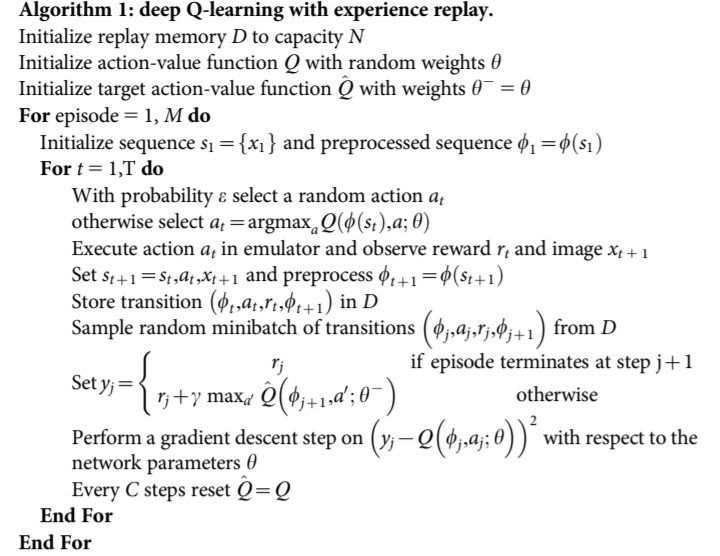

0. initialize e(decreasing leanerly) and Replay memory
0. initialize episode, starting state
1. for the given state take an action based on e-greedy_policy ( e decreases with time)
    - How am i going to extrapolate the th eta-greedy ( dont know)
2. observe st,at,rt+1,st+1 and save in the replay memory
3. create a mini batch, taken at random from the current replay memory
    4. calculate and update the weights of the network based on the batch
    5. if there are 5(C) updates made, then copy the weights of the current network to the target network.
4. continue the 
6. check if the average score for the last 100 episode >= 200


acmodel = NN_model(input_size=8, hidden_layer_sizes=[64,64],
                                     output_size=4, act=nn.SELU)
#.to(device)

datar = torch.from_numpy(np.array([env.reset(),env.reset()]))
#.to(device)
with torch.no_grad():
    #print(acmodel(datar),acmodel(datar).max().view(1,1) )
    print(acmodel(datar)
          .argmax()
          .item())

While Training:
1. score for every episode, with number of steps per episode

While testing:
1. score for 100 episodes, with number of steps per episode

hyperparameters to explore:
1. epsilon decay
2. gamma
3. learning rate
4. loss function:
    - Number of episode to achieve the goal.
    - total operational time taken for the achive the goal
    - Any major patterns while learning.
    - behaviour of the model after learning:
        - how it drops down: any piculiar behaviour.
        - % of wins after training.
        - avg speed ( number of steps per episode) to reach the goal.
        - avg score per 100 episodes.
5. difference between 200 target vs 250 target.


In [565]:
class Deep_Q_Network3:
    def __init__(self, env , gamma = 0.99,alpha = 0.0005,batch_size = 64, 
                 epsilon_start = 1,epsilon_min = 0.01,C = 3, N = 1, epsilon_end = 1000,epsilon_decay = 0.00005,eps_dcay_lim = 0,
                 epsilon_change_state =0, replay_memory = 100000,
                 lambda_ = 1, input_size=8, hidden_layer_sizes=[256,128], output_size=4,
                 act=nn.SELU, model_data_dir ="./model_data/",address_modifier ="test_data_check",specific_path="",
                 act_name ="SELU",env_name="LunarLander_v2",addition_details ="", save_option = 1, return_option =1,
                active_model = None, goal_model =None,target_model =None, target_update =True, learning_new =True,
                 super_goal =250, sub_goal =200, seed = 1
                 
                ):
        
        
        
        
        self.seed = seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
        env.seed(self.seed)
        env.action_space.seed(self.seed)
        
        
        
        
        # init environment
        self.env = env
        self.env_name=env_name
        self.act_name=act_name
        
        if (specific_path != "") and os.path.exists(specific_path):
            self.dir_name = specific_path
        else:
            self.model_data_dir = model_data_dir+address_modifier
            self.addition_details = addition_details
            if not os.path.exists(model_data_dir):
                os.mkdir(model_data_dir)
            if not os.path.exists(self.model_data_dir):
                os.mkdir(self.model_data_dir)
            #self.dir_name = self.model_data_dir+'./'+self.act_name+"_"+self.env_name+"_"+self.addition_details
            self.dir_name = self.model_data_dir+'/'+self.act_name+"_"+self.env_name+"_"+self.addition_details
        
        
        self.save_option = save_option
        self.return_option = return_option 

        #experience replay buffer
        self.replay_memory  = deque(maxlen= replay_memory) #int(1e5))
        # discount factor
        self.gamma = gamma
        #learning rate
        self.alpha = alpha
        self.epsilon_change_state =epsilon_change_state
        if (self.epsilon_change_state ==1):
            self.epsilon_decay = epsilon_decay*0.3
        else:
            self.epsilon_decay = epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon = epsilon_start        
        self.epsilon_min = epsilon_min
        self.epsilon_end = epsilon_end
        self.eps_dcay_lim = eps_dcay_lim
        self.epsilon_delta = (self.epsilon_start - self.epsilon_min)/self.epsilon_end
        self.lambda_ = lambda_
        # frequency with which target network is updated.
        self.C = C
        
        self.N = N
        
        
        # number of experience tuples used in computing the gradient descent parameter update.
        self.batch_size= batch_size
        self.episode_counter =0
        self.param_update_counter =0
        self.state_counter =0
        self.target_update = target_update
        self.super_goal =super_goal
        self.sub_goal =sub_goal
        
        self.input_size=input_size 
        self.hidden_layer_sizes=hidden_layer_sizes
        self.output_size=output_size
        self.act = act

        
        
        #handling input models, to continue training and testing of any existing model
        #usage of target model during learning is subject to "target_update" flag 
                
        self.handle_models(active_model = active_model, goal_model =goal_model,target_model =target_model, learning_new =learning_new )
        
        self.loss = nn.MSELoss()
        self.optimizer = optim.AdamW(self.active_model.parameters(),lr=self.alpha)        
        
        
    def handle_models(self, active_model = None, goal_model =None,target_model =None, learning_new =True ):
        
        if(learning_new ==True):
            self.active_model = NN_model(input_size=self.input_size, hidden_layer_sizes=self.hidden_layer_sizes,
                                     output_size=self.output_size, act=self.act,seed = self.seed)

            self.target_model = NN_model(input_size=self.input_size, hidden_layer_sizes=self.hidden_layer_sizes,
                                 output_size=self.output_size, act=self.act,seed = self.seed)             
        else:
            if(active_model == None):
                if(target_model == None):
                    if(goal_model == None):
                        self.active_model = NN_model(input_size=self.input_size, hidden_layer_sizes=self.hidden_layer_sizes,
                                                 output_size=self.output_size, act=self.act,seed = self.seed)

                        self.target_model = NN_model(input_size=self.input_size, hidden_layer_sizes=self.hidden_layer_sizes,
                                             output_size=self.output_size, act=self.act) 
                        self.goal_model = NN_model(input_size=self.input_size, hidden_layer_sizes=self.hidden_layer_sizes,
                                             output_size=self.output_size, act=self.act,seed = self.seed) 

                    else:
                        self.active_model = copy.deepcopy(goal_model)
                        self.target_model = copy.deepcopy(goal_model)
                        self.goal_model = goal_model


                else:
                    self.active_model = copy.deepcopy(target_model)
                    self.target_model = target_model

                    if(goal_model == None):
                        self.goal_model = copy.deepcopy(target_model)
                    else:
                        self.goal_model = goal_model
            else:
                self.active_model = active_model

                if(target_model == None):
                    self.target_model = copy.deepcopy(active_model)
                else:
                    self.target_model = target_model 



                if(goal_model == None):
                    self.goal_model = copy.deepcopy(active_model)
                else:
                    self.goal_model = goal_model
        
        
    def update_epsilon(self):
        if self.eps_dcay_lim == 1:
            if self.episode_counter < self.epsilon_end:
                self.epsilon -= self.epsilon_delta
            else:
                self.epsilon = self.epsilon_min
        else:
            if self.epsilon > self.epsilon_min:
                #print(self.epsilon,self.epsilon_min,self.epsilon_decay )
                self.epsilon -= self.epsilon_decay 
            else:
                self.epsilon = self.epsilon_min        
        
    def choose_action(self, state):
        if np.random.random(1)[0] < self.epsilon:
            action  = self.env.action_space.sample()
        else:
            self.active_model.eval()
            with torch.no_grad():
                action_values = self.active_model(torch.Tensor(state))
            self.active_model.train()

            # choose the greedy action
            action = (action_values.argmax().item()) 
            
        return(action)
        
        
        
    def _learning(self):
        
        #update active model
        states, targets_forecast =[],[]
        
        mini_batch = random.sample(self.replay_memory, self.batch_size)
        
        state, action, reward, next_state, done = (torch.Tensor(x) for x in zip(*mini_batch))
        
        
        if(self.target_update == True):
            Q_t1 = self.target_model(next_state).detach().max(dim=1)[0]
        else:
            Q_t1 = self.active_model(next_state).detach().max(dim=1)[0]
        
        
        # compute the new Q' values using the Q-learning formula
        Q_t_prime = reward + (self.gamma*Q_t1*(1-done))
        
        # get expected Q values from local model
        action_number = (action.long().unsqueeze(dim=1))
        expected_Q_a = (self.active_model(state).gather(dim=1, index=action_number))
        # compute the mean squared loss
        loss = self.loss(Q_t_prime.unsqueeze(dim=1),expected_Q_a)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.param_update_counter +=1
        if((self.target_update == True) and (self.param_update_counter % self.N == 0)):
            self.param_update_counter = 0
            self.target_model.load_state_dict(self.active_model.state_dict())
        #self.target_model == copy.deepcopy(self.active_model)
        
        #adjusting epsilon
        if (self.epsilon_change_state ==0):
            self.update_epsilon()
                    
        
        #update target model
        
        
    def run_experience_and_learn(self):
        
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
        self.env.seed(self.seed)
        self.env.action_space.seed(self.seed)
        
        
        
        
        
        
        
        #replay memory is already inisitalized
        #action value function Q with random weights is taken care by the model
        
        avg_score = 0
        score_list = []
        step_count_list =[]
        execution_time_list =[]
        #epsilon_list =[]
        score_que = deque(maxlen = 100)
        step_count = 0
        
        reached_goal_1_flag = 0
        reached_goal_1_details =[]
        
        
        while(avg_score <self.super_goal):
            
            if (reached_goal_1_flag ==0) and (avg_score >=self.sub_goal):
                self.goal_model = copy.deepcopy(self.active_model)
                reached_goal_1_flag = 1
                reached_goal_1_details = [self.episode_counter, avg_score]
            
            
            score = 0
            current_state = self.env.reset() 
            
            self.episode_counter +=1
            

            episode_step_count = 0
            
            start_time = time.time()
            #current_state = np.append(current_state,[episode_step_count])
            while(True):
                    
                #choosing action
                action = self.choose_action(current_state)
                
                step_count +=1
                episode_step_count+=1                    

                next_state, reward, done, _ = self.env.step(action)
                #next_state = np.append(next_state,[episode_step_count])
                score += reward
                #reward += - (0.001*episode_step_count)**2
                
                
                #appending to the memory
                self.replay_memory.append([current_state,action,reward,next_state,done])

                current_state = next_state
                #skipping experiences
                if (len(self.replay_memory)> self.batch_size) and (step_count%self.C ==0):
                    self._learning()
                
                if (self.epsilon_change_state ==1):
                    self.update_epsilon()
                    
                if done:# or episode_step_count >400:
                    break
                

                        
                
            score_list.append(score)
            step_count_list.append(episode_step_count)
            execution_time_list.append(start_time-time.time())
            score_que.append(score)
            if(len(score_que)==100):
                avg_score = np.mean(score_que)
            if(self.episode_counter %100 ==0):
                print("episode: ",  self.episode_counter, "avg_score :" , avg_score , " epsilon :", self.epsilon )
            
            if((self.episode_counter >6000) or (avg_score <-800) ):
                print("not able to find near optimal policy")
                if (reached_goal_1_flag ==0):
                    self.goal_model = copy.deepcopy(self.active_model)
                    reached_goal_1_flag = 1             

                break
        
        print('Complete')
        #env.render()
        #env.close()
       
        pd_Data_df = pd.DataFrame({"Score": score_list,"step_count":step_count_list,"exec_time": execution_time_list})
        pd_Data_df["rolling_step_count"] =pd_Data_df.step_count.rolling(100).mean()
        pd_Data_df["rolling_Score"] =pd_Data_df.Score.rolling(100).mean()
        
        if(self.save_option ==1):
            self.pd_model_save(pd_Data_df=pd_Data_df,file_name="training_model_info.csv", goal_model_save = True, active_model_save = True  )
        
        if(self.return_option ==1):
            return(pd_Data_df)
    
    
    def pd_model_save(self,pd_Data_df,file_name, goal_model_save = False, active_model_save = False  ):
            if not os.path.exists(self.dir_name):
                os.mkdir(self.dir_name)
            
            pd_Data_df.to_csv(os.path.join(self.dir_name,file_name)) 
            
            if(active_model_save):
                torch.save(self.active_model, os.path.join(self.dir_name,"active_model"))
            if(goal_model_save):
                torch.save(self.goal_model, os.path.join(self.dir_name,"goal_model"))                
    
    
    def run_tests(self, model = None, model_num = 1, episodes = 100):
        torch.manual_seed(self.seed+1)
        torch.cuda.manual_seed(self.seed+1)
        torch.cuda.manual_seed_all(self.seed+1)
        np.random.seed(self.seed+1)
        random.seed(self.seed+1)
        self.env.seed(self.seed+1)
        self.env.action_space.seed(self.seed+1)
        
        if (model_num == 1):
            model =self.active_model
            file_name = 'test_model_info_'+str(self.super_goal)+'.csv'
        elif model_num == 0:
            model = self.goal_model
            file_name = 'test_model_info_'+str(self.sub_goal)+'.csv'
        else:
            file_name = "test_model_info.csv"
            
        
        score_list = []
        step_count_list =[]
        execution_time_list =[]
        
        # since the backpropagation is not used and optimzer does not take steps , the model is not learning here
        for i_episode in range(episodes):
            observation = self.env.reset()
            score = 0
            
            episode_step_count = 0
            
            start_time = time.time()
            
            model.eval()

            for t in range(2000):
                with torch.no_grad():
                    action = model(torch.Tensor(observation)).detach().argmax().numpy()
                observation, reward, done, info = self.env.step(action)
                score += reward

                episode_step_count += 1

                if done:
                    break    
        
            score_list.append(score)
            step_count_list.append(episode_step_count)
            execution_time_list.append(start_time-time.time())
            
        pd_Data_df = pd.DataFrame({"Score": score_list,"step_count":step_count_list,"exec_time": execution_time_list})
        
        if(self.save_option ==1):
            self.pd_model_save(pd_Data_df=pd_Data_df,file_name=file_name, goal_model_save = False, active_model_save = False  )
        
        if(self.return_option ==1):
            return(pd_Data_df)
        
        
        
        
        
        

In [351]:
def save_gif(model, env,location, count = 1,seed=1, save = True):
    frames_RELU = []
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)
    
    for i_episode in range(count):
        observation = env.reset()
        score = 0
        for t in range(2000):
            frames_RELU.append(env.render(mode = 'rgb_array'))
            action = model(torch.Tensor(observation)).detach().argmax().numpy()
            observation, reward, done, info = env.step(action)
            score+=reward
            if done:
                print("Reward: ",score, "timesteps",(t+1), "model", location[13:])
                break
    env.close()
    if save:
        imageio.mimsave(location+"/model_.gif", frames_RELU,fps =60)

In [600]:
def get_data_from_csv(base_address = "./model_data/",address_modifier= "test_data_check/"):
    address_modifier = address_modifier+"*"
    training_model_info = pd.DataFrame(columns=['Unnamed: 0','Score','step_count','exec_time','rolling_step_count','rolling_Score','model_identifier','identifier_param','loss_fn_env','model_name'])
    test_model_info_200 = pd.DataFrame(columns=['Unnamed: 0','Score','step_count','exec_time','model_identifier','identifier_param','loss_fn_env','model_name'])
    test_model_info_250 = pd.DataFrame(columns=['Unnamed: 0','Score','step_count','exec_time','model_identifier','identifier_param','loss_fn_env','model_name'])
    
    experiment_group_list = ["base","C_*","_N_*",
                             "repeat_*","gamma_*","ep_end_*","alpha_*","ep_decay_*","batch_size_*","state_space_*","replay_memory_size_*"]
    
    
    
    if not os.path.exists(base_address+address_modifier[:-1]):
        os.mkdir(base_address+address_modifier[:-1])
    
    
    for i in experiment_group_list:
        k = glob.glob(base_address+address_modifier+i)
        for j in k:

            model_identifier = (i[:-2] if(i!= "base") else "base")
            identifier_param = j[j.find(i[:-1])+len(i[:-1]):]
            loss_fn_env = j[len(base_address+address_modifier)-1:j.find(i[:-1])-1]
            mode_name = j[len(base_address+address_modifier)-1:]
            #print(model_identifier,identifier_param,over_all_model)

            data_model_info = pd.read_csv(j+"/training_model_info.csv")
            data_model_info["model_identifier"] =model_identifier
            data_model_info["identifier_param"]=identifier_param
            data_model_info["loss_fn_env"] = loss_fn_env
            data_model_info["model_name"] = mode_name
            
            
            data_model_200 = pd.read_csv(j+"/test_model_info_200.csv")
            data_model_200["model_identifier"] =model_identifier
            data_model_200["identifier_param"]=identifier_param
            data_model_200["loss_fn_env"] = loss_fn_env
            data_model_200["model_name"] =mode_name
            
            
            data_model_250 = pd.read_csv(j+"/test_model_info_250.csv")
            data_model_250["model_identifier"] =model_identifier
            data_model_250["identifier_param"]=identifier_param
            data_model_250["loss_fn_env"] = loss_fn_env
            data_model_250["model_name"] = mode_name
            

            training_model_info = training_model_info.append(data_model_info,ignore_index =True)
            test_model_info_200 = test_model_info_200.append(data_model_200,ignore_index =True)
            test_model_info_250 = test_model_info_250.append(data_model_250,ignore_index =True)
            #if(num >2):
            #    break
    training_model_info.columns=list(["episode_no"]) +list(training_model_info.columns[1:])
    test_model_info_200.columns=list(["episode_no"]) +list(test_model_info_200.columns[1:])
    test_model_info_250.columns=list(["episode_no"]) +list(test_model_info_250.columns[1:])
    
    
    training_model_info["reached_goal"] = np.nan
    training_model_info["more_than_200"] = training_model_info["rolling_Score"]>200

    training_model_info.loc[training_model_info[training_model_info["more_than_200"]
                       ].groupby(["model_name"]).apply(lambda x: x["rolling_Score"].idxmin()).values,"reached_goal"] =True

    training_model_info["for_goal_analysis"] =  training_model_info.apply(lambda x : (x["reached_goal"] == True) or (x["more_than_200"] == False), axis =1)
    test_model_info_200["reached_goal"] = (test_model_info_200["Score"]>=200).apply(lambda x: int(x))
    test_model_info_250["reached_goal"] = (test_model_info_250["Score"]>=200).apply(lambda x: int(x))
    test_model_info_200["Hovering"] = (test_model_info_200["step_count"]==1000).apply(lambda x: int(x))
    test_model_info_250["Hovering"] = (test_model_info_250["step_count"]==1000).apply(lambda x: int(x))
    training_model_info['exec_time'] = -1*training_model_info['exec_time']
    
    training_model_info["rolling_exec_time"] = training_model_info.groupby("model_name").exec_time.rolling(100).mean().values
    
    
    
    training_model_info.to_csv(base_address+address_modifier[:-1]+"training_model_info_all_models.csv")
    test_model_info_200.to_csv(base_address+address_modifier[:-1]+"test_model_info_200_all_models.csv")
    test_model_info_250.to_csv(base_address+address_modifier[:-1]+"test_model_info_250_all_models.csv")
    
    return(training_model_info, test_model_info_200,test_model_info_250)
    


In [ ]:


def Auto_test_all_models( env = gym.make('LunarLander-v2'), base_address = "./model_data/", address_modifier = "test_data_check/*"):
    #env = gym.make('LunarLander-v2')
    #address_modifier = "test_data_check/*"
    k = glob.glob(base_address+address_modifier)
    for j in k:
        print(j)
        active_model = torch.load(j+"/active_model")
        goal_model = torch.load(j+"/goal_model")

        param_dict = {"env":env,"specific_path":j,
                     'active_model' : active_model,'return_option' :0, 'goal_model' :goal_model, 'target_update' :True, 'learning_new' :False,
                      'seed' : 2
                     }

        dqn = Deep_Q_Network3(**param_dict)
        dqn.run_tests(model_num = 1)
        dqn.run_tests(model_num = 0)
    
    
    
Auto_test_all_models()
    
                   
                    
                    


While Training:
1. score for every episode, with number of steps per episode

While testing:
1. score for 100 episodes, with number of steps per episode

hyperparameters to explore:
1. epsilon decay
2. gamma
3. learning rate
4. loss function:
    - Number of episode to achieve the goal.
    - total operational time taken for the achive the goal
    - Any major patterns while learning.
    - behaviour of the model after learning:
        - how it drops down: any piculiar behaviour.
        - % of wins after training.
        - avg speed ( number of steps per episode) to reach the goal.
        - avg score per 100 episodes.
5. difference between 200 target vs 250 target.


In [332]:
dictionary_loop = [{'env' : gym.make('LunarLander-v2'), 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"base"},
                   {'env' : gym.make('LunarLander-v2'), 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.ReLU,'act_name' :"ReLU",'env_name':"LunarLander_v2",'addition_details':"base"},
                   {'env' : gym.make('LunarLander-v2'), 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.GELU,'act_name' :"GELU",'env_name':"LunarLander_v2",'addition_details':"base"}
                  ]


model_list = []
train_data =[]
test_data_250 =[]
test_data_200 =[]

for n,i in enumerate(dictionary_loop):
        model_list.append(Deep_Q_Network3(**i))
        train_data.append(model_list[n].run_experience_and_learn())
        test_data_250.append(model_list[n].run_tests(model_num = 1))
        test_data_200.append(model_list[n].run_tests(model_num = 0))

episode:  100 avg_score : -141.83129050682683  epsilon : 0.8503000000000165
episode:  200 avg_score : -88.58220603092545  epsilon : 0.664050000000037
episode:  300 avg_score : -54.780345439892635  epsilon : 0.01
episode:  400 avg_score : -38.376898032117936  epsilon : 0.01
episode:  500 avg_score : 161.87203696736185  epsilon : 0.01
episode:  600 avg_score : 184.2495116195692  epsilon : 0.01
episode:  700 avg_score : 237.45890941819485  epsilon : 0.01
Complete
episode:  100 avg_score : -145.90363745742633  epsilon : 0.8446000000000171
episode:  200 avg_score : -88.40326842985368  epsilon : 0.6315000000000406
episode:  300 avg_score : -70.58277582119537  epsilon : 0.01
episode:  400 avg_score : -42.24606422752597  epsilon : 0.01
episode:  500 avg_score : 123.96399412326379  epsilon : 0.01
episode:  600 avg_score : 218.14747326069764  epsilon : 0.01
episode:  700 avg_score : 168.15315702936005  epsilon : 0.01
episode:  800 avg_score : 199.4970831051756  epsilon : 0.01
episode:  900 avg_s

## extensively testing LeakyRLU

### Does LeakyRLU generally have less training time

In [464]:
model_list_repeat_test = []
train_data_repeat_test  =[]
test_data_250_repeat_test  =[]
test_data_200_repeat_test  =[]

repeat_range = range(10)


dictionary_loop_repeat_test = [{'env' : gym.make('LunarLander-v2'), 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"repeat_"+str(i),"seed":i}
                              for i in repeat_range
                  ]



for n,i in enumerate(dictionary_loop_repeat_test):
    
    model_list_repeat_test.append(Deep_Q_Network3(**i))
    train_data_repeat_test.append(model_list_repeat_test[n].run_experience_and_learn())
    test_data_250_repeat_test.append(model_list_repeat_test[n].run_tests(model_num = 1))
    test_data_200_repeat_test.append(model_list_repeat_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -136.47023125356742  epsilon : 0.8413500000000175
episode:  200 avg_score : -96.74914614657746  epsilon : 0.6469000000000389
episode:  300 avg_score : -57.124066893539606  epsilon : 0.01
episode:  400 avg_score : -45.21427206151253  epsilon : 0.01
episode:  500 avg_score : -43.50332775655481  epsilon : 0.01
episode:  600 avg_score : 29.519515712823065  epsilon : 0.01
episode:  700 avg_score : 146.90763205906157  epsilon : 0.01
episode:  800 avg_score : 201.57383751440688  epsilon : 0.01
episode:  900 avg_score : 222.18172086387742  epsilon : 0.01
episode:  1000 avg_score : 227.1977343458715  epsilon : 0.01
episode:  1100 avg_score : 245.64321635049032  epsilon : 0.01
Complete
episode:  100 avg_score : -141.83129050682683  epsilon : 0.8503000000000165
episode:  200 avg_score : -88.58220603092545  epsilon : 0.664050000000037
episode:  300 avg_score : -54.780345439892635  epsilon : 0.01
episode:  400 avg_score : -38.376898032117936  epsilon : 0.01
episode:  500 a

it is observed that 1 out of 10 attempts, i.e 10%, took more than 1500 episodes to achive the extended goal of scoring 250.

however all of the procedured converge to the goal of 200 score before 800 episodes

### Does the training time for reaching the goal changes with gamma

In [333]:
model_list_gamma_test = []
train_data_gamma_test  =[]
test_data_250_gamma_test  =[]
test_data_200_gamma_test  =[]

gamma_range = [1,0.99,0.8,0.5,0.4,0.3]


dictionary_loop_gamma_test = [{'env' : gym.make('LunarLander-v2'),'gamma' : i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"gamma_"+str(i)}
                              for i in gamma_range
                  ]



for n,i in enumerate(dictionary_loop_gamma_test):
    
    model_list_gamma_test.append(Deep_Q_Network3(**i))
    train_data_gamma_test.append(model_list_gamma_test[n].run_experience_and_learn())
    test_data_250_gamma_test.append(model_list_gamma_test[n].run_tests(model_num = 1))
    test_data_200_gamma_test.append(model_list_gamma_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -177.93307651064882  epsilon : 0.8448500000000171
episode:  200 avg_score : -269.34865879619474  epsilon : 0.63695000000004
episode:  300 avg_score : -399.44868305396966  epsilon : 0.41670000000006424
episode:  400 avg_score : -587.9225552752255  epsilon : 0.191900000000089
episode:  500 avg_score : -765.9658422326695  epsilon : 0.01
not able to find near optimal policy
Complete
episode:  100 avg_score : -141.83129050682683  epsilon : 0.8503000000000165
episode:  200 avg_score : -88.58220603092545  epsilon : 0.664050000000037
episode:  300 avg_score : -54.780345439892635  epsilon : 0.01
episode:  400 avg_score : -38.376898032117936  epsilon : 0.01
episode:  500 avg_score : 161.87203696736185  epsilon : 0.01
episode:  600 avg_score : 184.2495116195692  epsilon : 0.01
episode:  700 avg_score : 237.45890941819485  epsilon : 0.01
Complete
episode:  100 avg_score : -152.3223157463966  epsilon : 0.827600000000019
episode:  200 avg_score : -117.90025298640934  epsilo

episode:  5800 avg_score : -13.04506235868081  epsilon : 0.01
episode:  5900 avg_score : -35.73136073162769  epsilon : 0.01
episode:  6000 avg_score : -41.23239406485147  epsilon : 0.01
not able to find near optimal policy
Complete
episode:  100 avg_score : -161.40285354816046  epsilon : 0.8417500000000174
episode:  200 avg_score : -135.3947919553485  epsilon : 0.6446500000000391
episode:  300 avg_score : -131.6382720671491  epsilon : 0.2588500000000816
episode:  400 avg_score : -288.82282744079225  epsilon : 0.01
episode:  500 avg_score : -156.01465743821433  epsilon : 0.01
episode:  600 avg_score : -109.00609900212348  epsilon : 0.01
episode:  700 avg_score : -200.747848489001  epsilon : 0.01
episode:  800 avg_score : -88.77877128162152  epsilon : 0.01
episode:  900 avg_score : -29.300418624171115  epsilon : 0.01
episode:  1000 avg_score : -45.46219682525774  epsilon : 0.01
episode:  1100 avg_score : -14.479550293661882  epsilon : 0.01
episode:  1200 avg_score : -45.30790793457966  e

When the actions are guided by near future rewards, for the given learning rate, the agent may want to hower in the air as compared to getting down, landing, which may lead to crashing.

maybe larger learning rate will push the model to change the perception faster.
since the dependency is high on the imidiate observation, if given a chance to explore more the model can probably learn.

### Different explorations ranges

In [335]:
model_list_delimma_test = []
train_data_delimma_test  =[]
test_data_250_delimma_test  =[]
test_data_200_delimma_test  =[]

#epsilon_decay_range = [0.0001,0.00005,0.00001,0.000005]
epsilon_decay_range = [0.0001,0.00001,0.000005]
dictionary_loop_delimma_test = [{'env' : gym.make('LunarLander-v2'),'epsilon_decay' : i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"ep_decay_"+str(i)}
                              for i in epsilon_decay_range
                  ]


for n,i in enumerate(dictionary_loop_delimma_test):
    
    model_list_delimma_test.append(Deep_Q_Network3(**i))
    train_data_delimma_test.append(model_list_delimma_test[n].run_experience_and_learn())
    test_data_250_delimma_test.append(model_list_delimma_test[n].run_tests(model_num = 1))
    test_data_200_delimma_test.append(model_list_delimma_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -137.07463078511023  epsilon : 0.6537000000000381
episode:  200 avg_score : -59.154598966069464  epsilon : 0.01
episode:  300 avg_score : -41.00502737275546  epsilon : 0.01
episode:  400 avg_score : 49.26080081388858  epsilon : 0.01
episode:  500 avg_score : 80.87370596614673  epsilon : 0.01
episode:  600 avg_score : 223.45830111719056  epsilon : 0.01
episode:  700 avg_score : 237.58652802622146  epsilon : 0.01
episode:  800 avg_score : 222.09791222774922  epsilon : 0.01
episode:  900 avg_score : 248.27797766278283  epsilon : 0.01
Complete
episode:  100 avg_score : -173.09189319975368  epsilon : 0.9688200000001419
episode:  200 avg_score : -160.8081754529307  epsilon : 0.9364800000002891
episode:  300 avg_score : -122.25347411058395  epsilon : 0.9049400000004326
episode:  400 avg_score : -122.16185873741013  epsilon : 0.8737800000005744
episode:  500 avg_score : -114.34528294142508  epsilon : 0.8348700000007515
episode:  600 avg_score : -111.23689216098671  ep

### learning rate 

In [336]:
model_list_learning_rate_test = []
train_data_learning_rate_test  =[]
test_data_250_learning_rate_test  =[]
test_data_200_learning_rate_test  =[]

alpha_range = [0.01, 0.005, 0.001,0.0005,0.0001]

dictionary_loop_learning_rate_test = [{'env' : gym.make('LunarLander-v2'),'alpha' : i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"alpha_"+str(i)}
                              for i in alpha_range
                  ]


for n,i in enumerate(dictionary_loop_learning_rate_test):
    
    model_list_learning_rate_test.append(Deep_Q_Network3(**i))
    train_data_learning_rate_test.append(model_list_learning_rate_test[n].run_experience_and_learn())
    test_data_250_learning_rate_test.append(model_list_learning_rate_test[n].run_tests(model_num = 1))
    test_data_200_learning_rate_test.append(model_list_learning_rate_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -193.98713960141893  epsilon : 0.8373500000000179
episode:  200 avg_score : -292.7599942746134  epsilon : 0.6465500000000389
episode:  300 avg_score : -437.76628432179695  epsilon : 0.42040000000006383
episode:  400 avg_score : -584.4179647636735  epsilon : 0.2029000000000878
episode:  500 avg_score : -685.8251307751586  epsilon : 0.01
episode:  600 avg_score : -429.2632319874507  epsilon : 0.01
episode:  700 avg_score : -130.85877122282616  epsilon : 0.01
episode:  800 avg_score : -221.80960080377974  epsilon : 0.01
episode:  900 avg_score : -352.7707776723614  epsilon : 0.01
episode:  1000 avg_score : -406.6809733837085  epsilon : 0.01
episode:  1100 avg_score : -521.3351583514064  epsilon : 0.01
episode:  1200 avg_score : -609.9780061427425  epsilon : 0.01
episode:  1300 avg_score : -651.8841321174679  epsilon : 0.01
episode:  1400 avg_score : -643.6309517016851  epsilon : 0.01
episode:  1500 avg_score : -661.6828362413036  epsilon : 0.01
episode:  1600 avg

hypothesis , the reliability on the high exploration models is higher.

In [ ]:
interesting learning rate : 0.001 : selective learning ... over fitting in between.

### Target network update frequency

In [338]:
model_list_update_rate_test = []
train_data_update_rate_test  =[]
test_data_250_update_rate_test  =[]
test_data_200_update_rate_test  =[]

N_range = [1,3,10,50,100,500,1000,5000]

#setting update the per action
dictionary_loop_update_rate_test = [{'env' : gym.make('LunarLander-v2'),"N": i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"_N_"+str(i)}
                              for i in N_range
                  ]


for n,i in enumerate(dictionary_loop_update_rate_test):

    model_list_update_rate_test.append(Deep_Q_Network3(**i))
    train_data_update_rate_test.append(model_list_update_rate_test[n].run_experience_and_learn())
    test_data_250_update_rate_test.append(model_list_update_rate_test[n].run_tests(model_num = 1))
    test_data_200_update_rate_test.append(model_list_update_rate_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -141.83129050682683  epsilon : 0.8503000000000165
episode:  200 avg_score : -88.58220603092545  epsilon : 0.664050000000037
episode:  300 avg_score : -54.780345439892635  epsilon : 0.01
episode:  400 avg_score : -38.376898032117936  epsilon : 0.01
episode:  500 avg_score : 161.87203696736185  epsilon : 0.01
episode:  600 avg_score : 184.2495116195692  epsilon : 0.01
episode:  700 avg_score : 237.45890941819485  epsilon : 0.01
Complete
episode:  100 avg_score : -142.24314831069177  epsilon : 0.8378000000000179
episode:  200 avg_score : -89.07029621806602  epsilon : 0.6609500000000373
episode:  300 avg_score : -81.22516881542353  epsilon : 0.050750000000102914
episode:  400 avg_score : -53.310210222581446  epsilon : 0.01
episode:  500 avg_score : -37.01199488537655  epsilon : 0.01
episode:  600 avg_score : 37.89184702832771  epsilon : 0.01
episode:  700 avg_score : 170.24621541164694  epsilon : 0.01
episode:  800 avg_score : 192.90254142904044  epsilon : 0.01
ep

### Skip rate

In [339]:
model_list_skip_rate_test = []
train_data_skip_rate_test  =[]
test_data_250_skip_rate_test  =[]
test_data_200_skip_rate_test  =[]

C_range = [1,3,10,50,100]

#setting update the per action
dictionary_loop_skip_rate_test = [{'env' : gym.make('LunarLander-v2'),'C' : i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"C_"+str(i)}
                              for i in C_range
                  ]


for n,i in enumerate(dictionary_loop_skip_rate_test):
    
    model_list_skip_rate_test.append(Deep_Q_Network3(**i))
    train_data_skip_rate_test.append(model_list_skip_rate_test[n].run_experience_and_learn())
    test_data_250_skip_rate_test.append(model_list_skip_rate_test[n].run_tests(model_num = 1))
    test_data_200_skip_rate_test.append(model_list_skip_rate_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -105.65182499483988  epsilon : 0.41470000000006446
episode:  200 avg_score : -46.30066931287296  epsilon : 0.01
episode:  300 avg_score : -34.26183004456053  epsilon : 0.01
episode:  400 avg_score : 158.4870952077076  epsilon : 0.01
episode:  500 avg_score : 247.8830560242678  epsilon : 0.01
episode:  600 avg_score : 229.68215429155237  epsilon : 0.01
Complete
episode:  100 avg_score : -141.83129050682683  epsilon : 0.8503000000000165
episode:  200 avg_score : -88.58220603092545  epsilon : 0.664050000000037
episode:  300 avg_score : -54.780345439892635  epsilon : 0.01
episode:  400 avg_score : -38.376898032117936  epsilon : 0.01
episode:  500 avg_score : 161.87203696736185  epsilon : 0.01
episode:  600 avg_score : 184.2495116195692  epsilon : 0.01
episode:  700 avg_score : 237.45890941819485  epsilon : 0.01
Complete
episode:  100 avg_score : -175.41781635051234  epsilon : 0.9537500000000051
episode:  200 avg_score : -146.30588360039846  epsilon : 0.90645000000

episode:  2200 avg_score : -129.00029854227344  epsilon : 0.8938000000000117
episode:  2300 avg_score : -142.13006165882393  epsilon : 0.8888000000000122
episode:  2400 avg_score : -133.21032684542405  epsilon : 0.8839000000000128
episode:  2500 avg_score : -126.79577002284812  epsilon : 0.8785000000000134
episode:  2600 avg_score : -126.42318141381645  epsilon : 0.8734000000000139
episode:  2700 avg_score : -131.9620396772308  epsilon : 0.8684500000000145
episode:  2800 avg_score : -123.23251706492437  epsilon : 0.863350000000015
episode:  2900 avg_score : -128.29538373569036  epsilon : 0.8584500000000156
episode:  3000 avg_score : -125.23479343093008  epsilon : 0.8526000000000162
episode:  3100 avg_score : -111.90064405577589  epsilon : 0.8475000000000168
episode:  3200 avg_score : -120.59372148025216  epsilon : 0.8425000000000173
episode:  3300 avg_score : -119.7303681190986  epsilon : 0.836850000000018
episode:  3400 avg_score : -121.41215512073462  epsilon : 0.8306500000000187
epi

### Representation of the state space in approximation.

In [340]:
model_list_state_space_test = []
train_data_state_space_test = []
test_data_250_state_space_test = []
test_data_200_state_space_test = []

neuron_range = [32,64,128,256]

dictionary_loop_state_space_test = [{'env' : gym.make('LunarLander-v2'), 'input_size':8,'hidden_layer_sizes':[i,i],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"state_space_"+str(i)}
                              for i in neuron_range
                  ]


for n,i in enumerate(dictionary_loop_state_space_test):
    
    model_list_state_space_test.append(Deep_Q_Network3(**i))
    train_data_state_space_test.append(model_list_state_space_test[n].run_experience_and_learn())
    test_data_250_state_space_test.append(model_list_state_space_test[n].run_tests(model_num = 1))
    test_data_200_state_space_test.append(model_list_state_space_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -173.93554701012957  epsilon : 0.8490500000000166
episode:  200 avg_score : -120.74917155038936  epsilon : 0.6667000000000367
episode:  300 avg_score : -94.92896667557255  epsilon : 0.2655500000000809
episode:  400 avg_score : -51.74068196783006  epsilon : 0.01
episode:  500 avg_score : -5.356118521613487  epsilon : 0.01
episode:  600 avg_score : -6.148979319198543  epsilon : 0.01
episode:  700 avg_score : -17.65609758652894  epsilon : 0.01
episode:  800 avg_score : 41.80617720760171  epsilon : 0.01
episode:  900 avg_score : 100.20383056239028  epsilon : 0.01
episode:  1000 avg_score : 68.37497921429366  epsilon : 0.01
episode:  1100 avg_score : 108.47166472468383  epsilon : 0.01
episode:  1200 avg_score : 88.55952714968082  epsilon : 0.01
episode:  1300 avg_score : 113.16937274768632  epsilon : 0.01
episode:  1400 avg_score : 148.7009929236763  epsilon : 0.01
episode:  1500 avg_score : 156.15296942415108  epsilon : 0.01
episode:  1600 avg_score : 173.96429614

it requires atleast 64 neural states in each hidden layer to generalize the states showing associated behaviour.
we can achive the goal with less neurons ( 32) as well, however the representation is not generall enough for all the states, and therefore can also be chance occurance.



Additionally, as the size of the neural network grows, that is the number of states used for aproximation increases, the precisions of the action increases as well, and therefore more consistently higher scores can be achived, faster.



### batch size check

In [341]:
model_list_batch_test = []
train_data_batch_test = []
test_data_250_batch_test = []
test_data_200_batch_test = []

batch_size_range = [8,32,64,128,256]

dictionary_loop_batch_test = [{'env' : gym.make('LunarLander-v2'),'batch_size' : i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"batch_size_"+str(i)}
                              for i in batch_size_range
                  ]


for n,i in enumerate(dictionary_loop_batch_test):
    
    model_list_batch_test.append(Deep_Q_Network3(**i))
    train_data_batch_test.append(model_list_batch_test[n].run_experience_and_learn())
    test_data_250_batch_test.append(model_list_batch_test[n].run_tests(model_num = 1))
    test_data_200_batch_test.append(model_list_batch_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -149.1517621707185  epsilon : 0.836600000000018
episode:  200 avg_score : -108.63869720821843  epsilon : 0.6429000000000393
episode:  300 avg_score : -105.71784605256937  epsilon : 0.24015000000008369
episode:  400 avg_score : -74.45479730128717  epsilon : 0.01
episode:  500 avg_score : -37.65406035604751  epsilon : 0.01
episode:  600 avg_score : 5.210096456427936  epsilon : 0.01
episode:  700 avg_score : 53.51446287677193  epsilon : 0.01
episode:  800 avg_score : 109.39001860233871  epsilon : 0.01
episode:  900 avg_score : 53.244161791497916  epsilon : 0.01
episode:  1000 avg_score : 49.70647365334419  epsilon : 0.01
episode:  1100 avg_score : 63.47799404751141  epsilon : 0.01
episode:  1200 avg_score : 62.265730274678866  epsilon : 0.01
episode:  1300 avg_score : 94.95012962657081  epsilon : 0.01
episode:  1400 avg_score : 45.47530781440905  epsilon : 0.01
episode:  1500 avg_score : 83.13505316025734  epsilon : 0.01
episode:  1600 avg_score : 46.746044474481

for a given configuration and cetrain fixed replay buffer the accuracy of the trained model increased with increase in the batch size, however can decrease, if the matchsize is too large : reason, with every update the model tends to move towards a better estimate, however, if initially when the estimations are not correct enough, a larger batch of the low rewarding action presentation can add incorrect biases and therfore slow convergence.



### The size of replay memory

In [342]:
model_list_replay_memory_test = []
train_data_replay_memory_test = []
test_data_250_replay_memory_test = []
test_data_200_replay_memory_test = []

replay_memory_size_range = [5000,10000,50000,100000,500000]

dictionary_loop_replay_memory_test = [{'env' : gym.make('LunarLander-v2'),'replay_memory' : i, 'input_size':8,'hidden_layer_sizes':[128,128],'output_size':4,
                 'act':nn.LeakyReLU,'act_name' :"LeakyReLU",'env_name':"LunarLander_v2",'addition_details':"replay_memory_size_"+str(i)}
                              for i in replay_memory_size_range
                  ]


for n,i in enumerate(dictionary_loop_replay_memory_test):
    
    model_list_replay_memory_test.append(Deep_Q_Network3(**i))
    train_data_replay_memory_test.append(model_list_replay_memory_test[n].run_experience_and_learn())
    test_data_250_replay_memory_test.append(model_list_replay_memory_test[n].run_tests(model_num = 1))
    test_data_200_replay_memory_test.append(model_list_replay_memory_test[n].run_tests(model_num = 0))

episode:  100 avg_score : -143.8553191732173  epsilon : 0.8490000000000166
episode:  200 avg_score : -96.83479908516262  epsilon : 0.6605000000000374
episode:  300 avg_score : -56.81917893032935  epsilon : 0.1564500000000929
episode:  400 avg_score : -13.409895211887928  epsilon : 0.01
episode:  500 avg_score : -137.0197588468364  epsilon : 0.01
episode:  600 avg_score : -38.46314994635477  epsilon : 0.01
episode:  700 avg_score : -33.61385087410235  epsilon : 0.01
episode:  800 avg_score : -51.332415659099425  epsilon : 0.01
episode:  900 avg_score : -47.87151022746161  epsilon : 0.01
episode:  1000 avg_score : 25.506326925809308  epsilon : 0.01
episode:  1100 avg_score : 198.719802035873  epsilon : 0.01
episode:  1200 avg_score : 208.26953239623074  epsilon : 0.01
episode:  1300 avg_score : 162.05821538874855  epsilon : 0.01
episode:  1400 avg_score : 192.19656694618936  epsilon : 0.01
episode:  1500 avg_score : 54.010625928028794  epsilon : 0.01
episode:  1600 avg_score : 245.611197

with very large memory, the model learning is highly dependent on the stochiatic choosing of the elements to to create minibatchs, 

False achivement, if the model is able to pass the results in the learning phase, it need not mean it will also perform in the testing phase, as due to chance options, which training, it might so have happend that a specific kind of historically learnt pattern is repeated, achiving the goal criteria, however due to this reason the model is not able to generallize in the testing phase, and therefore is not ablet o achive the goal criteria when used. therefore it might be helpfull to be choosie about the kind of enxperience observed by the model ( in some manner) and hence  a tighter memory might be good


## Creating Model Gifs

In [349]:
experiment_group_list = ["base","C_*","_N_*",
                         "repeat_*","gamma_*","alpha_*","ep_decay_*","batch_size_*","state_space_*", "replay_memory_size_*"]

env = gym.make('LunarLander-v2')
for i in experiment_group_list:
    k = glob.glob("./model_data/test_data_check/*"+i)
    for j in k:
        revived_model = torch.load(j+"/active_model")
        save_gif(revived_model, env,j)

Reward:  110.84156333414046 timesteps 1000 model GELU_LunarLander_v2_base
Reward:  303.56653764034866 timesteps 230 model LeakyReLU_LunarLander_v2_base
Reward:  290.04461929047613 timesteps 250 model ReLU_LunarLander_v2_base
Reward:  293.6922654501012 timesteps 241 model LeakyReLU_LunarLander_v2_C_1
Reward:  253.96875398506367 timesteps 322 model LeakyReLU_LunarLander_v2_C_10
Reward:  -171.37130960895183 timesteps 348 model LeakyReLU_LunarLander_v2_C_100
Reward:  303.56653764034866 timesteps 230 model LeakyReLU_LunarLander_v2_C_3
Reward:  162.09385139196974 timesteps 1000 model LeakyReLU_LunarLander_v2_C_50
Reward:  303.56653764034866 timesteps 230 model LeakyReLU_LunarLander_v2__N_1
Reward:  290.2651708153803 timesteps 226 model LeakyReLU_LunarLander_v2__N_10
Reward:  173.77978776465804 timesteps 1000 model LeakyReLU_LunarLander_v2__N_100
Reward:  226.99731816166033 timesteps 340 model LeakyReLU_LunarLander_v2__N_1000
Reward:  280.642779617384 timesteps 303 model LeakyReLU_LunarLander

In [745]:

def Auto_gif_creator( env = gym.make('LunarLander-v2'), base_address = "./model_data/", address_modifier = "test_data_check/*"):
    experiment_group_list = ["base","C_*","_N_*",
                             "repeat_*","gamma_*","alpha_*","ep_decay_*","batch_size_*","state_space_*", "replay_memory_size_*"]

    for i in experiment_group_list:
        k = glob.glob(base_address+address_modifier+i)
        for j in k:
            revived_model = torch.load(j+"/active_model")
            save_gif(revived_model, env,j)

In [520]:
#batch_size_



experiment_group_list = ["base","C_*","_N_*",
                         "repeat_*","gamma_*","alpha_*","ep_decay_*","batch_size_*","state_space_*", "replay_memory_size_*"]

env = gym.make('LunarLander-v2')
for i in experiment_group_list:
    k = glob.glob("./model_data/*"+i)
    for j in k:
        revived_model = torch.load(j+"/active_model")
        save_gif(revived_model, env,j)



def batch_func(i = "batch_size_*"):
    k = glob.glob("./model_data/*"+i)
    for j in k:
        revived_model = torch.load(j+"/active_model")
        save_gif(revived_model, env,j)

        
for i        
batch_func()

Reward:  294.8066753560246 timesteps 215 model LeakyReLU_LunarLander_v2_batch_size_128
Reward:  295.22350596927413 timesteps 211 model LeakyReLU_LunarLander_v2_batch_size_256
Reward:  251.37438854713866 timesteps 286 model LeakyReLU_LunarLander_v2_batch_size_32
Reward:  303.56653764034866 timesteps 230 model LeakyReLU_LunarLander_v2_batch_size_64
Reward:  249.98564608894898 timesteps 460 model LeakyReLU_LunarLander_v2_batch_size_8


with small gamma, it does not learn to use the main engine and there swindles down....
additionally.... many a times it does not learn to do to the center dirrectly but drags itself

in cases like space sate = 64 ... it is more causions and it comes down very slowly , but runs out of time, even through moving to the right diretion


## Aggrigating Model training and testing data for further analysis

In [521]:
base_address = "./model_data/"
address_modifier= "test_data_check/"

training_model_info, test_model_info_200,test_model_info_250 = get_data_from_csv(address_modifier=address_modifier)

### Reading data back from the saved aggrigated file And creating ADS for Analysis

In [744]:
test_model_info_200.columns

Index(['episode_no', 'Score', 'step_count', 'exec_time', 'model_identifier',
       'identifier_param', 'loss_fn_env', 'model_name', 'reached_goal',
       'Hovering'],
      dtype='object')

In [633]:
def data_handler():

    training_model_info, test_model_info_200,test_model_info_250 = (pd.read_csv(base_address+address_modifier+"training_model_info_all_models.csv"),
                                                                    pd.read_csv(base_address+address_modifier+"test_model_info_200_all_models.csv"),
                                                                    pd.read_csv(base_address+address_modifier+"test_model_info_250_all_models.csv"))



    training_model_info.drop("Unnamed: 0",inplace = True,axis =1)
    test_model_info_200.drop("Unnamed: 0",inplace = True,axis =1)
    test_model_info_250.drop("Unnamed: 0",inplace = True,axis =1)









    training_model_info["step_count_cumsum"]= training_model_info.sort_values(['model_name','episode_no'], ascending = [True,True]).groupby(['model_name'])['step_count'].cumsum()
    training_model_info["exec_time_cumsum"]= training_model_info.sort_values(['model_name','episode_no'], ascending = [True,True]).groupby(['model_name'])['exec_time'].cumsum()


    table_for_analysis = training_model_info.iloc[training_model_info.groupby(["model_identifier",'identifier_param']).episode_no.idxmax(),].loc[training_model_info["model_identifier"] != "base",]
    table_for_analysis.loc[:,'identifier_param']= table_for_analysis['identifier_param'].astype("float64")
    table_for_analysis_grouped = table_for_analysis.groupby("model_identifier")



    table_for_analysis_goal = training_model_info.loc[training_model_info["reached_goal"] == True, ].loc[training_model_info["model_identifier"] != "base",]
    table_for_analysis_goal.loc[:,'identifier_param']= table_for_analysis_goal['identifier_param'].astype("float64")
    table_for_analysis_goal_grouped = table_for_analysis_goal.groupby("model_identifier")




    table_for_analysis_250_0 = test_model_info_250.groupby(["model_name",'loss_fn_env','identifier_param','model_identifier']).agg({
        'Score':(nanmean,'std'),'step_count' : (nanmean,'std') ,'exec_time' : (nanmean,'std') ,
        'reached_goal': 'sum','Hovering': 'sum'
    }).reset_index()

    table_for_analysis_250 = table_for_analysis_250_0.loc[table_for_analysis_250_0["model_identifier"] != "base",]



    table_for_analysis_250.loc[:,'identifier_param']= table_for_analysis_250['identifier_param'].astype("float64")
    table_for_analysis_250_grouped = table_for_analysis_250.groupby("model_identifier")


    table_for_analysis_200_0 = test_model_info_200.groupby(["model_name",'loss_fn_env','identifier_param','model_identifier']).agg({
        'Score':(nanmean,'std'),'step_count' : (nanmean,'std') ,'exec_time' : (nanmean,'std') ,
        'reached_goal': 'sum','Hovering': 'sum'
    }).reset_index()

    table_for_analysis_200 = table_for_analysis_200_0.loc[table_for_analysis_200_0["model_identifier"] != "base",]



    table_for_analysis_200.loc[:,'identifier_param']= table_for_analysis_200['identifier_param'].astype("float64")
    table_for_analysis_200_grouped = table_for_analysis_200.groupby("model_identifier")



    #for name,group in table_for_analysis_250_grouped:
    #    display(group.sort_values(["identifier_param",('Score',"nanmean")], ascending= [True,False]))


    table_for_analysis_250.to_csv(base_address+address_modifier+"test_250_analytical_overview.csv")
    table_for_analysis_200.to_csv(base_address+address_modifier+"test_200_analytical_overview.csv")
    table_for_analysis.to_csv(base_address+address_modifier+"train_end_analytical_overview.csv")
    table_for_analysis_goal.to_csv(base_address+address_modifier+"train_200_analytical_overview.csv")



    for name,group in table_for_analysis_grouped:
        print(name,"training_200")
        display(table_for_analysis_goal_grouped.get_group(name).sort_values(["identifier_param","episode_no",'rolling_Score'], ascending= [True,True,False]))

        print(name,"training_end")
        display(group.sort_values(["identifier_param","episode_no",'rolling_Score'], ascending= [True,True,False]))
        print("test_250")
        display(table_for_analysis_250_grouped.get_group(name).sort_values(["identifier_param",('Score',"nanmean")], ascending= [True,False]))
        print("test_200")
        display(table_for_analysis_200_grouped.get_group(name).sort_values(["identifier_param",('Score',"nanmean")], ascending= [True,False]))
    
    
    return(training_model_info,test_model_info_200,test_model_info_250,table_for_analysis_250,table_for_analysis_200,table_for_analysis,table_for_analysis_goal)
    
#faster learning, low episode count,
#smoother learning = low deviation during training
# good performance low step count, low avg score,low failures and low deviation

training_model_info,test_model_info_200,test_model_info_250,table_for_analysis_250,table_for_analysis_200,table_for_analysis,table_for_analysis_goal = data_handler()    

C training_200


C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
3686,414,278.767328,311,0.816817,499.52,201.064814,C,1.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_1,True,True,True,0.597492,269365,931.884461
12657,635,226.281654,398,0.583440,390.29,200.172030,C,3.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_3,True,True,True,0.022011,248396,420.166136
5544,1577,295.855255,309,0.183510,411.67,200.019251,C,10.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_10,True,True,True,0.022699,614216,736.056373
18060,5323,217.861954,407,0.233376,481.35,201.476322,C,50.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_50,True,True,True,2.260569,1216747,922.985213


C training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
3966,694,307.317913,215,0.510635,284.58,250.492137,C,1.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_1,NaN,True,False,0.262508,359469,1179.923012
12736,714,223.836169,325,0.455782,342.99,250.830586,C,3.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_3,NaN,True,False,0.022839,275439,455.434803
6020,2053,299.922319,252,0.155585,298.94,250.107594,C,10.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_10,NaN,True,False,0.015369,778338,868.359461
18737,6000,262.699645,266,0.132646,404.63,193.279503,C,50.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_50,NaN,False,True,2.002746,1507208,1147.662239
12021,6000,-30.084621,130,0.034906,121.29,-73.678756,C,100.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_C_100,NaN,False,True,0.018072,634647,134.924522


test_250


model_name               loss_fn_env identifier_param  \
                                                                               
1    LeakyReLU_LunarLander_v2_C_1  LeakyReLU_LunarLander_v2              1.0   
4    LeakyReLU_LunarLander_v2_C_3  LeakyReLU_LunarLander_v2              3.0   
2   LeakyReLU_LunarLander_v2_C_10  LeakyReLU_LunarLander_v2             10.0   
5   LeakyReLU_LunarLander_v2_C_50  LeakyReLU_LunarLander_v2             50.0   
3  LeakyReLU_LunarLander_v2_C_100  LeakyReLU_LunarLander_v2            100.0   

  model_identifier       Score            step_count             exec_time  \
                       nanmean        std    nanmean         std   nanmean   
1                C  268.884973  25.044614     281.19  105.249458 -0.156481   
4                C  224.438711  78.834754     374.27  224.915062 -0.332589   
2                C  244.853686  51.364839     353.17  240.906246 -0.251184   
5                C  183.242047  72.683638     627.46  369.745624 -0.714174   
3                C -129.044629  41.961880     937.90  183.443025 -1.564992   

            reached_goal Hovering  
        std          sum      sum  
1  0.133344           98        2  
4  0.359566           79        8  
2  0.309528           88       11  
5  0.582807           45       47  
3  0.566216            0       88

test_200


model_name               loss_fn_env identifier_param  \
                                                                               
1    LeakyReLU_LunarLander_v2_C_1  LeakyReLU_LunarLander_v2              1.0   
4    LeakyReLU_LunarLander_v2_C_3  LeakyReLU_LunarLander_v2              3.0   
2   LeakyReLU_LunarLander_v2_C_10  LeakyReLU_LunarLander_v2             10.0   
5   LeakyReLU_LunarLander_v2_C_50  LeakyReLU_LunarLander_v2             50.0   
3  LeakyReLU_LunarLander_v2_C_100  LeakyReLU_LunarLander_v2            100.0   

  model_identifier       Score             step_count             exec_time  \
                       nanmean         std    nanmean         std   nanmean   
1                C  145.689249  138.878337     373.28  182.632992 -0.286783   
4                C  254.340457   23.574744     354.46   40.863018 -0.269838   
2                C  148.216047  133.542772     582.31  291.479912 -0.685851   
5                C  212.694314   67.518345     396.80  184.148765 -0.306909   
3                C -129.044629   41.961880     937.90  183.443025 -1.691745   

            reached_goal Hovering  
        std          sum      sum  
1  0.279519           51        5  
4  0.091433           98        0  
2  0.602854           52       29  
5  0.225217           74        5  
3  1.468415            0       88

_N training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
19373,635,226.281654,398,0.881642,390.29,200.172030,_N,1.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_1,True,True,True,0.082479,248396,592.285707
23158,817,287.466236,292,0.500628,426.19,200.023252,_N,3.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_3,True,True,True,2.039176,422001,1028.113095
20009,556,307.465788,249,0.317151,417.73,201.912958,_N,10.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_10,True,True,True,0.307837,230481,515.935694
24218,611,261.286953,461,0.826787,439.82,200.024361,_N,50.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_50,True,True,True,1.638817,240260,498.135161
20773,718,163.609892,396,0.529583,439.54,200.082113,_N,100.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_100,True,True,True,0.152270,388961,710.309722
25276,835,229.735174,195,0.197471,426.32,200.033119,_N,500.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_500,True,True,True,1.804244,475528,891.408688
22097,1052,287.842330,285,0.299201,385.99,200.346509,_N,1000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_1000,True,True,True,0.714848,537761,940.885330
27629,2028,211.821496,352,0.439824,433.27,200.061668,_N,5000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_5000,True,True,True,0.403371,1323366,2366.289746


_N training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
19452,714,223.836169,325,0.744010,342.99,250.830586,_N,1.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_1,NaN,True,False,0.123170,275439,647.131068
23606,1265,224.969017,419,0.800859,334.58,251.946769,_N,3.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_3,NaN,True,False,0.425562,575158,1292.200922
20054,601,242.808985,338,0.585434,333.55,251.510237,_N,10.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_10,NaN,True,False,0.298053,244093,538.640938
24440,833,233.279148,229,0.267284,305.28,250.525790,_N,50.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_50,NaN,True,False,1.236772,310384,595.080852
21044,989,208.105666,493,0.711096,333.51,252.560023,_N,100.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_100,NaN,True,False,2.714783,480433,826.221685
25600,1159,293.925589,253,0.269279,252.34,250.062236,_N,500.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_500,NaN,True,False,0.875478,567105,1002.968337
22340,1295,266.956948,233,0.228389,320.14,250.191125,_N,1000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_1000,NaN,True,False,0.929045,616124,1039.210355
29609,4008,247.091989,223,0.259306,235.36,251.817225,_N,5000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2__N_5000,NaN,True,False,2.622741,2097382,3527.014776


test_250


model_name               loss_fn_env  \
                                                                 
6      LeakyReLU_LunarLander_v2__N_1  LeakyReLU_LunarLander_v2   
10     LeakyReLU_LunarLander_v2__N_3  LeakyReLU_LunarLander_v2   
7     LeakyReLU_LunarLander_v2__N_10  LeakyReLU_LunarLander_v2   
11    LeakyReLU_LunarLander_v2__N_50  LeakyReLU_LunarLander_v2   
8    LeakyReLU_LunarLander_v2__N_100  LeakyReLU_LunarLander_v2   
12   LeakyReLU_LunarLander_v2__N_500  LeakyReLU_LunarLander_v2   
9   LeakyReLU_LunarLander_v2__N_1000  LeakyReLU_LunarLander_v2   
13  LeakyReLU_LunarLander_v2__N_5000  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score            step_count  \
                                         nanmean        std    nanmean   
6               1.0               _N  224.438711  78.834754     374.27   
10              3.0               _N  264.153260  27.083192     304.83   
7              10.0               _N  244.405339  59.507849     375.77   
11             50.0               _N  234.085781  52.549375     367.46   
8             100.0               _N  254.225350  47.924920     357.81   
12            500.0               _N  256.198078  35.195639     307.47   
9            1000.0               _N  207.169683  71.897789     448.90   
13           5000.0               _N  240.768614  43.111737     240.58   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
6   224.915062 -0.323514  0.335338           79        8  
10   99.576990 -0.180357  0.114330           99        1  
7   259.096521 -0.275872  0.277826           84       11  
11  235.628814 -0.306271  0.328309           84       10  
8   232.755592 -0.284210  0.288548           88       11  
12  191.464291 -0.190351  0.208024           94        6  
9   289.611705 -0.417544  0.399823           64       18  
13  172.096883 -0.146239  0.184283           90        4

test_200


model_name               loss_fn_env  \
                                                                 
6      LeakyReLU_LunarLander_v2__N_1  LeakyReLU_LunarLander_v2   
10     LeakyReLU_LunarLander_v2__N_3  LeakyReLU_LunarLander_v2   
7     LeakyReLU_LunarLander_v2__N_10  LeakyReLU_LunarLander_v2   
11    LeakyReLU_LunarLander_v2__N_50  LeakyReLU_LunarLander_v2   
8    LeakyReLU_LunarLander_v2__N_100  LeakyReLU_LunarLander_v2   
12   LeakyReLU_LunarLander_v2__N_500  LeakyReLU_LunarLander_v2   
9   LeakyReLU_LunarLander_v2__N_1000  LeakyReLU_LunarLander_v2   
13  LeakyReLU_LunarLander_v2__N_5000  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
6               1.0               _N  254.340457   23.574744     354.46   
10              3.0               _N  234.071584   44.174954     412.43   
7              10.0               _N  211.680156   75.478817     694.13   
11             50.0               _N  232.598345   59.583519     389.99   
8             100.0               _N  135.546010  120.318980     403.09   
12            500.0               _N  137.391351  146.317843     578.75   
9            1000.0               _N  242.026760   36.581913     385.73   
13           5000.0               _N  168.971996   96.724367     526.82   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
6    40.863018 -0.263276  0.081168           98        0  
10  187.887633 -0.387135  0.353695           91        8  
7   289.251722 -0.709911  0.410188           62       34  
11  177.298156 -0.293784  0.237121           77        3  
8   232.102515 -0.371625  0.337243           41        8  
12  344.997156 -0.610367  0.566095           55       38  
9   150.377294 -0.305972  0.230181           90        5  
13  302.529617 -0.549331  0.517111           51       21

alpha training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
67032,2889,-4.296302,354,0.509637,455.57,200.141942,alpha,0.0001,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.0001,True,True,True,0.679165,2266899,5483.121620
68369,635,226.281654,398,0.781909,390.29,200.172030,alpha,0.0005,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.0005,True,True,True,0.598310,248396,532.562874
69210,761,-465.377383,82,0.103724,334.05,200.222972,alpha,0.0010,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.001,True,True,True,NaN,317260,668.578467


alpha training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
65535,1392,-121.663557,1000,1.939812,1000.00,-97.493757,alpha,0.0001,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.0001,NaN,False,True,0.831067,1038757,2511.148796
67733,3590,257.516863,345,0.591417,324.11,250.961440,alpha,0.0001,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.0001,NaN,True,False,0.489411,2558659,6036.679535
68448,714,223.836169,325,0.535567,342.99,250.830586,alpha,0.0005,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.0005,NaN,True,False,0.662358,275439,578.907961
70227,1778,304.424044,271,0.376981,340.26,250.489397,alpha,0.0010,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.001,NaN,True,False,0.578981,805045,1685.433335
70900,672,-916.494336,404,0.746005,163.61,-807.072927,alpha,0.0050,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.005,NaN,False,True,0.632788,179052,332.042709
76054,5153,-3551.475652,334,0.526592,114.47,-822.388967,alpha,0.0100,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_alpha_0.01,NaN,False,True,1.322399,720545,1044.624179


test_250


model_name               loss_fn_env  \
                                                                      
14  LeakyReLU_LunarLander_v2_alpha_0.0001  LeakyReLU_LunarLander_v2   
15  LeakyReLU_LunarLander_v2_alpha_0.0005  LeakyReLU_LunarLander_v2   
16   LeakyReLU_LunarLander_v2_alpha_0.001  LeakyReLU_LunarLander_v2   
17   LeakyReLU_LunarLander_v2_alpha_0.005  LeakyReLU_LunarLander_v2   
18    LeakyReLU_LunarLander_v2_alpha_0.01  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier        Score             step_count  \
                                          nanmean         std    nanmean   
14           0.0001            alpha   266.426512   20.394531     305.23   
15           0.0005            alpha   224.438711   78.834754     374.27   
16           0.0010            alpha   203.229682   68.560596     557.99   
17           0.0050            alpha -1073.241334  480.384813     253.46   
18           0.0100            alpha  -883.159710  613.816695     125.93   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
14   32.097344 -0.222830  0.063555          100        0  
15  224.915062 -0.302587  0.317342           79        8  
16  303.587423 -0.555990  0.468144           67       28  
17  129.768202 -0.169327  0.135357            0        0  
18   60.826173 -0.059361  0.048103            0        0

test_200


model_name               loss_fn_env  \
                                                                      
14  LeakyReLU_LunarLander_v2_alpha_0.0001  LeakyReLU_LunarLander_v2   
15  LeakyReLU_LunarLander_v2_alpha_0.0005  LeakyReLU_LunarLander_v2   
16   LeakyReLU_LunarLander_v2_alpha_0.001  LeakyReLU_LunarLander_v2   
17   LeakyReLU_LunarLander_v2_alpha_0.005  LeakyReLU_LunarLander_v2   
18    LeakyReLU_LunarLander_v2_alpha_0.01  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier        Score             step_count  \
                                          nanmean         std    nanmean   
14           0.0001            alpha   218.467525   72.139102     388.04   
15           0.0005            alpha   254.340457   23.574744     354.46   
16           0.0010            alpha   237.028803   42.819248     403.92   
17           0.0050            alpha -1073.241334  480.384813     253.46   
18           0.0100            alpha  -883.159710  613.816695     125.93   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
14   89.970918 -0.296337  0.119889           84        1  
15   40.863018 -0.238522  0.072733           98        0  
16  209.777548 -0.284609  0.239229           90        8  
17  129.768202 -0.170205  0.136540            0        0  
18   60.826173 -0.059431  0.047393            0        0

batch_size training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
85518,914,208.381082,414,0.503652,427.66,200.113320,batch_size,32.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_32,True,True,True,1.739190,429800,687.670157
86690,635,226.281654,398,0.612360,390.29,200.172030,batch_size,64.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_64,True,True,True,0.580567,248396,456.669411
83378,626,276.417279,446,1.039254,431.70,201.783083,batch_size,128.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_128,True,True,True,0.551198,287380,647.618625
84264,576,185.551277,332,0.744043,404.55,200.152788,batch_size,256.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_256,True,True,True,NaN,218134,561.146811


batch_size training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
92770,6000,133.870554,989,1.840075,765.13,46.708349,batch_size,8.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_8,NaN,False,True,0.096551,3555033,5422.111963
86054,1450,299.965078,199,0.175515,264.41,250.862605,batch_size,32.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_32,NaN,True,False,0.115860,594016,880.101164
86769,714,223.836169,325,0.489728,342.99,250.830586,batch_size,64.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_64,NaN,True,False,0.597413,275439,496.159774
83687,935,265.044427,206,0.307176,280.60,250.841115,batch_size,128.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_128,NaN,True,False,0.109497,390252,819.674291
84603,915,188.637008,440,1.326448,299.22,250.486677,batch_size,256.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_batch_size_256,NaN,True,False,2.364218,332230,817.513035


test_250


model_name               loss_fn_env  \
                                                                        
24    LeakyReLU_LunarLander_v2_batch_size_8  LeakyReLU_LunarLander_v2   
22   LeakyReLU_LunarLander_v2_batch_size_32  LeakyReLU_LunarLander_v2   
23   LeakyReLU_LunarLander_v2_batch_size_64  LeakyReLU_LunarLander_v2   
20  LeakyReLU_LunarLander_v2_batch_size_128  LeakyReLU_LunarLander_v2   
21  LeakyReLU_LunarLander_v2_batch_size_256  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score            step_count  \
                                         nanmean        std    nanmean   
24              8.0       batch_size  236.056263  38.779414     415.10   
22             32.0       batch_size  245.974395  58.796825     293.77   
23             64.0       batch_size  224.438711  78.834754     374.27   
20            128.0       batch_size  259.617937  37.886154     258.34   
21            256.0       batch_size  224.466621  60.719541     402.61   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
24  182.976043 -0.375077  0.281269           91        7  
22  231.175427 -0.180587  0.225052           88        9  
23  224.915062 -0.296228  0.296804           79        8  
20  173.957920 -0.155285  0.194313           94        5  
21  236.713521 -0.347151  0.363318           66        9

test_200


model_name               loss_fn_env  \
                                                                        
24    LeakyReLU_LunarLander_v2_batch_size_8  LeakyReLU_LunarLander_v2   
22   LeakyReLU_LunarLander_v2_batch_size_32  LeakyReLU_LunarLander_v2   
23   LeakyReLU_LunarLander_v2_batch_size_64  LeakyReLU_LunarLander_v2   
20  LeakyReLU_LunarLander_v2_batch_size_128  LeakyReLU_LunarLander_v2   
21  LeakyReLU_LunarLander_v2_batch_size_256  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
24              8.0       batch_size  236.056263   38.779414     415.10   
22             32.0       batch_size    8.248821  248.607809     601.97   
23             64.0       batch_size  254.340457   23.574744     354.46   
20            128.0       batch_size  246.752144   36.035975     367.29   
21            256.0       batch_size  220.777032   52.689612     460.20   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
24  182.976043 -0.317780  0.232727           91        7  
22  246.357114 -0.683811  0.514009           32       19  
23   40.863018 -0.263053  0.090240           98        0  
20  210.222407 -0.272731  0.230206           92        8  
21  190.326567 -0.440821  0.356766           77       10

ep_decay training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
82630,2988,215.654499,622,1.264618,621.18,200.427675,ep_decay,0.000005,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_5e-06,True,True,True,0.304347,531648,847.451443
78575,1615,249.968865,409,0.627325,462.83,200.019228,ep_decay,0.000010,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_1e-05,True,True,True,1.826849,326172,558.365410
79562,635,226.281654,398,0.794874,390.29,200.172030,ep_decay,0.000050,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_5e-05,True,True,True,1.541247,248396,561.299239
76622,567,-96.217959,473,0.750992,449.68,200.262803,ep_decay,0.000100,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_0.0001,True,True,True,1.487372,332266,785.950481


ep_decay training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
82751,3109,289.848188,265,0.493680,360.90,250.357795,ep_decay,0.000005,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_5e-06,NaN,True,False,2.564368,578060,927.717747
78926,1966,291.145945,244,0.342085,287.17,253.349560,ep_decay,0.000010,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_1e-05,NaN,True,False,1.594864,450121,778.529850
79641,714,223.836169,325,0.549531,342.99,250.830586,ep_decay,0.000050,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_5e-05,NaN,True,False,1.530906,275439,609.284879
76959,904,266.977364,186,0.231381,296.00,250.083249,ep_decay,0.000100,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_ep_decay_0.0001,NaN,True,False,1.906022,426294,932.963276


test_250


model_name               loss_fn_env  \
                                                                         
28   LeakyReLU_LunarLander_v2_ep_decay_5e-06  LeakyReLU_LunarLander_v2   
26   LeakyReLU_LunarLander_v2_ep_decay_1e-05  LeakyReLU_LunarLander_v2   
27   LeakyReLU_LunarLander_v2_ep_decay_5e-05  LeakyReLU_LunarLander_v2   
25  LeakyReLU_LunarLander_v2_ep_decay_0.0001  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score            step_count  \
                                         nanmean        std    nanmean   
28         0.000005         ep_decay  246.679383  41.719417     352.82   
26         0.000010         ep_decay  252.895854  35.670993     324.29   
27         0.000050         ep_decay  224.438711  78.834754     374.27   
25         0.000100         ep_decay  265.723508  29.954637     285.40   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
28  194.312587 -0.275328  0.262479           92        8  
26  221.195708 -0.219942  0.265394           91        9  
27  224.915062 -0.300706  0.311275           79        8  
25  160.204730 -0.170394  0.163624           96        3

test_200


model_name               loss_fn_env  \
                                                                         
28   LeakyReLU_LunarLander_v2_ep_decay_5e-06  LeakyReLU_LunarLander_v2   
26   LeakyReLU_LunarLander_v2_ep_decay_1e-05  LeakyReLU_LunarLander_v2   
27   LeakyReLU_LunarLander_v2_ep_decay_5e-05  LeakyReLU_LunarLander_v2   
25  LeakyReLU_LunarLander_v2_ep_decay_0.0001  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
28         0.000005         ep_decay  193.084512   81.452926     448.07   
26         0.000010         ep_decay  179.752584  101.154450     433.79   
27         0.000050         ep_decay  254.340457   23.574744     354.46   
25         0.000100         ep_decay  175.472916  127.201511     404.61   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
28  260.148375 -0.410761  0.358104           53       14  
26  273.786406 -0.326307  0.336983           58       15  
27   40.863018 -0.263599  0.095488           98        0  
25  157.689626 -0.306969  0.226185           65        2

gamma training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
63535,635,226.281654,398,0.682175,390.29,200.17203,gamma,0.99,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_0.99,True,True,True,0.79193,248396,484.356417


gamma training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
44896,6000,-47.903847,257,0.422869,308.51,-10.432377,gamma,0.30,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_0.3,NaN,False,True,1.457103,1981937,3484.188999
50897,6000,-6.457957,249,0.311168,335.39,-0.023247,gamma,0.40,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_0.4,NaN,False,True,1.573756,2152192,4203.130510
56898,6000,-164.203433,290,0.681179,349.74,-42.673852,gamma,0.50,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_0.5,NaN,False,True,1.723869,2050216,3885.276370
62899,6000,-119.351069,1000,2.079437,715.81,2.825099,gamma,0.80,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_0.8,NaN,False,True,0.709741,3993874,9244.393894
63614,714,223.836169,325,0.450793,342.99,250.830586,gamma,0.99,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_0.99,NaN,True,False,1.093445,275439,524.515984
64142,527,-1028.393968,143,0.189493,139.80,-800.519837,gamma,1.00,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_gamma_1,NaN,False,True,0.891085,66379,76.913264


test_250


model_name               loss_fn_env  \
                                                                    
29   LeakyReLU_LunarLander_v2_gamma_0.3  LeakyReLU_LunarLander_v2   
30   LeakyReLU_LunarLander_v2_gamma_0.4  LeakyReLU_LunarLander_v2   
31   LeakyReLU_LunarLander_v2_gamma_0.5  LeakyReLU_LunarLander_v2   
32   LeakyReLU_LunarLander_v2_gamma_0.8  LeakyReLU_LunarLander_v2   
33  LeakyReLU_LunarLander_v2_gamma_0.99  LeakyReLU_LunarLander_v2   
34     LeakyReLU_LunarLander_v2_gamma_1  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
29             0.30            gamma  -22.099499  187.644136     348.27   
30             0.40            gamma  -44.329104  197.029552     350.59   
31             0.50            gamma  -36.278842  184.787859     395.23   
32             0.80            gamma  -17.145929  159.851417     721.88   
33             0.99            gamma  224.438711   78.834754     374.27   
34             1.00            gamma -807.804523  524.914787     129.41   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
29  149.903461 -0.283741  0.233237           23        3  
30  103.111893 -0.269898  0.163588           27        0  
31  205.544306 -0.404827  0.442331           21        4  
32  261.660868 -0.981674  0.641056           14       42  
33  224.915062 -0.289755  0.300248           79        8  
34   53.111488 -0.059301  0.038168            0        0

test_200


model_name               loss_fn_env  \
                                                                    
29   LeakyReLU_LunarLander_v2_gamma_0.3  LeakyReLU_LunarLander_v2   
30   LeakyReLU_LunarLander_v2_gamma_0.4  LeakyReLU_LunarLander_v2   
31   LeakyReLU_LunarLander_v2_gamma_0.5  LeakyReLU_LunarLander_v2   
32   LeakyReLU_LunarLander_v2_gamma_0.8  LeakyReLU_LunarLander_v2   
33  LeakyReLU_LunarLander_v2_gamma_0.99  LeakyReLU_LunarLander_v2   
34     LeakyReLU_LunarLander_v2_gamma_1  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
29             0.30            gamma  -22.099499  187.644136     348.27   
30             0.40            gamma  -44.329104  197.029552     350.59   
31             0.50            gamma  -36.278842  184.787859     395.23   
32             0.80            gamma  -17.145929  159.851417     721.88   
33             0.99            gamma  254.340457   23.574744     354.46   
34             1.00            gamma -807.804523  524.914787     129.41   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
29  149.903461 -0.277109  0.231782           23        3  
30  103.111893 -0.267385  0.154165           27        0  
31  205.544306 -0.380412  0.408709           21        4  
32  261.660868 -0.981136  0.650351           14       42  
33   40.863018 -0.238043  0.069331           98        0  
34   53.111488 -0.057706  0.038509            0        0

repeat training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
30407,797,246.987925,399,0.687160,493.86,200.086600,repeat,0.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_0,True,True,True,1.000963,467006,1193.678901
31407,635,226.281654,398,0.822800,390.29,200.172030,repeat,1.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_1,True,True,True,NaN,248396,541.155143
32037,550,260.096120,292,0.476725,477.47,202.381849,repeat,2.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_2,True,True,True,0.669191,259530,584.913385
32842,623,205.390295,421,0.684170,490.64,201.735727,repeat,3.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_3,True,True,True,0.540265,314741,695.508457
33733,582,229.673019,294,0.449798,318.74,200.934799,repeat,4.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_4,True,True,True,0.645005,254062,603.025519
34853,714,228.476672,319,0.809834,410.10,200.084935,repeat,5.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_5,True,True,True,0.143158,359566,880.622973
35855,650,242.464245,301,0.434838,442.64,200.160815,repeat,6.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_6,True,True,True,0.121854,292583,696.985977
37077,582,257.268317,358,0.776923,400.05,200.344767,repeat,7.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_7,True,True,True,0.097998,256481,644.467961
37876,572,231.918903,314,0.569479,480.77,200.709742,repeat,8.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_8,True,True,True,0.284090,263181,702.445623
38739,668,265.776942,440,0.824762,481.74,200.093459,repeat,9.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_9,True,True,True,0.126920,316266,742.694612


repeat training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
30771,1161,281.902640,345,0.640288,319.16,250.845673,repeat,0.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_0,NaN,True,False,0.807765,593879,1426.513207
31486,714,223.836169,325,0.545541,342.99,250.830586,repeat,1.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_1,NaN,True,False,0.088603,275439,587.801229
32218,731,264.461487,356,0.529583,310.76,250.556978,repeat,2.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_2,NaN,True,False,0.116877,322064,683.030485
33150,931,262.539047,395,0.609373,352.23,250.266691,repeat,3.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_3,NaN,True,False,1.353958,446023,939.386987
34138,987,271.603011,282,0.488692,313.18,251.043436,repeat,4.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_4,NaN,True,False,0.140195,387231,835.436244
35204,1065,248.085953,315,0.542548,336.71,250.402311,repeat,5.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_5,NaN,True,False,0.073743,481591,1111.159369
36494,1289,244.614356,349,0.687162,316.27,250.157145,repeat,6.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_6,NaN,True,False,0.295250,500127,1073.523304
37303,808,262.443608,237,0.406912,307.98,250.074567,repeat,7.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_7,NaN,True,False,0.263336,327956,783.692139
38070,766,273.222865,304,0.557506,319.77,251.325413,repeat,8.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_8,NaN,True,False,0.249652,326400,820.091608
38895,824,265.344352,300,0.797866,324.16,250.381734,repeat,9.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_repeat_9,NaN,True,False,0.109367,368789,842.460239


test_250


model_name               loss_fn_env  \
                                                                  
35  LeakyReLU_LunarLander_v2_repeat_0  LeakyReLU_LunarLander_v2   
36  LeakyReLU_LunarLander_v2_repeat_1  LeakyReLU_LunarLander_v2   
37  LeakyReLU_LunarLander_v2_repeat_2  LeakyReLU_LunarLander_v2   
38  LeakyReLU_LunarLander_v2_repeat_3  LeakyReLU_LunarLander_v2   
39  LeakyReLU_LunarLander_v2_repeat_4  LeakyReLU_LunarLander_v2   
40  LeakyReLU_LunarLander_v2_repeat_5  LeakyReLU_LunarLander_v2   
41  LeakyReLU_LunarLander_v2_repeat_6  LeakyReLU_LunarLander_v2   
42  LeakyReLU_LunarLander_v2_repeat_7  LeakyReLU_LunarLander_v2   
43  LeakyReLU_LunarLander_v2_repeat_8  LeakyReLU_LunarLander_v2   
44  LeakyReLU_LunarLander_v2_repeat_9  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
35              0.0           repeat  267.182243   21.853631     264.05   
36              1.0           repeat  224.438711   78.834754     374.27   
37              2.0           repeat  260.613392   27.977181     313.91   
38              3.0           repeat  244.397215   42.450562     373.80   
39              4.0           repeat  266.124025   26.889447     261.58   
40              5.0           repeat  225.473413   45.248366     460.59   
41              6.0           repeat  261.743522   40.468648     291.98   
42              7.0           repeat  231.800101   61.071124     402.90   
43              8.0           repeat  158.331937  104.760057     486.31   
44              9.0           repeat  233.242300   69.273107     399.35   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
35   90.430773 -0.150976  0.100309           99        1  
36  224.915062 -0.293445  0.305409           79        8  
37  155.418633 -0.205191  0.194093           97        3  
38  169.417302 -0.281726  0.232476           94        5  
39  109.177751 -0.132246  0.092929           98        2  
40  201.275684 -0.406872  0.304929           84       11  
41  149.814294 -0.164899  0.159250           90        0  
42  257.068300 -0.318890  0.351263           83       14  
43  293.102619 -0.482619  0.464632           45       20  
44  121.566657 -0.297235  0.167550           97        3

test_200


model_name               loss_fn_env  \
                                                                  
35  LeakyReLU_LunarLander_v2_repeat_0  LeakyReLU_LunarLander_v2   
36  LeakyReLU_LunarLander_v2_repeat_1  LeakyReLU_LunarLander_v2   
37  LeakyReLU_LunarLander_v2_repeat_2  LeakyReLU_LunarLander_v2   
38  LeakyReLU_LunarLander_v2_repeat_3  LeakyReLU_LunarLander_v2   
39  LeakyReLU_LunarLander_v2_repeat_4  LeakyReLU_LunarLander_v2   
40  LeakyReLU_LunarLander_v2_repeat_5  LeakyReLU_LunarLander_v2   
41  LeakyReLU_LunarLander_v2_repeat_6  LeakyReLU_LunarLander_v2   
42  LeakyReLU_LunarLander_v2_repeat_7  LeakyReLU_LunarLander_v2   
43  LeakyReLU_LunarLander_v2_repeat_8  LeakyReLU_LunarLander_v2   
44  LeakyReLU_LunarLander_v2_repeat_9  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
35              0.0           repeat  120.548582   98.184437     647.34   
36              1.0           repeat  254.340457   23.574744     354.46   
37              2.0           repeat  234.360346   59.026791     350.24   
38              3.0           repeat  201.331297   74.622616     494.32   
39              4.0           repeat  233.427417   50.831994     375.35   
40              5.0           repeat  232.676710   57.330817     395.53   
41              6.0           repeat   33.652743  132.701757     258.23   
42              7.0           repeat  224.000374   47.047813     414.63   
43              8.0           repeat  148.007392  103.634347     508.34   
44              9.0           repeat  -11.454323  138.787849     743.95   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
35  269.988710 -0.683990  0.474968           23       24  
36   40.863018 -0.234622  0.068562           98        0  
37  142.716581 -0.210836  0.170362           91        4  
38  251.852846 -0.414681  0.337960           67       17  
39  199.252105 -0.254948  0.255998           87        7  
40  165.795691 -0.266268  0.174523           85        5  
41  210.348813 -0.139367  0.168995           15        4  
42  185.946156 -0.293754  0.216187           82        6  
43  221.733447 -0.510046  0.469701           44       11  
44  254.403457 -0.911083  0.510955           12       41

replay_memory_size training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
104477,1780,242.618686,428,0.751988,405.93,200.296916,replay_memory_size,5000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_5000,True,True,True,1.406997,976705,1832.093362
101677,635,278.646440,273,0.345077,381.65,201.554750,replay_memory_size,10000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_10000,True,True,True,1.344893,215092,344.244322
105117,606,227.524838,370,0.706112,434.40,201.453620,replay_memory_size,50000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_50000,True,True,True,0.942001,246121,445.770709
102617,635,226.281654,398,0.704118,390.29,200.172030,replay_memory_size,100000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_10...,True,True,True,0.582661,248396,464.161258
106123,811,256.520816,383,0.689157,446.37,200.383382,replay_memory_size,500000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_50...,True,True,True,2.401155,451662,1016.983199


replay_memory_size training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
104510,1813,230.388998,250,0.305184,300.33,250.889161,replay_memory_size,5000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_5000,NaN,True,False,1.271668,986079,1843.887812
101981,939,245.419583,267,0.305182,307.47,252.418400,replay_memory_size,10000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_10000,NaN,True,False,1.048236,318786,492.043902
105311,800,260.789987,425,0.648266,367.80,250.706435,replay_memory_size,50000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_50000,NaN,True,False,0.601969,311781,539.507942
102696,714,223.836169,325,0.517615,342.99,250.830586,replay_memory_size,100000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_10...,NaN,True,False,0.486140,275439,507.926136
106825,1513,249.989740,267,0.460766,326.09,250.840806,replay_memory_size,500000.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_replay_memory_size_50...,NaN,True,False,0.556003,689525,1472.134816


test_250


model_name  \
                                                        
47   LeakyReLU_LunarLander_v2_replay_memory_size_5000   
45  LeakyReLU_LunarLander_v2_replay_memory_size_10000   
48  LeakyReLU_LunarLander_v2_replay_memory_size_50000   
46  LeakyReLU_LunarLander_v2_replay_memory_size_10...   
49  LeakyReLU_LunarLander_v2_replay_memory_size_50...   

                 loss_fn_env identifier_param    model_identifier       Score  \
                                                                      nanmean   
47  LeakyReLU_LunarLander_v2           5000.0  replay_memory_size  254.772721   
45  LeakyReLU_LunarLander_v2          10000.0  replay_memory_size  263.912077   
48  LeakyReLU_LunarLander_v2          50000.0  replay_memory_size  257.792189   
46  LeakyReLU_LunarLander_v2         100000.0  replay_memory_size  224.438711   
49  LeakyReLU_LunarLander_v2         500000.0  replay_memory_size  243.428809   

              step_count             exec_time           reached_goal Hovering  
          std    nanmean         std   nanmean       std          sum      sum  
47  62.610298     280.01   52.409324 -0.178366  0.062703           96        0  
45  40.354651     280.32  139.856700 -0.167343  0.167516           93        3  
48  31.854439     304.05  182.402395 -0.219254  0.225085           95        5  
46  78.834754     374.27  224.915062 -0.344559  0.351877           79        8  
49  51.964541     298.11  141.225223 -0.204678  0.141153           90        3

test_200


model_name  \
                                                        
47   LeakyReLU_LunarLander_v2_replay_memory_size_5000   
45  LeakyReLU_LunarLander_v2_replay_memory_size_10000   
48  LeakyReLU_LunarLander_v2_replay_memory_size_50000   
46  LeakyReLU_LunarLander_v2_replay_memory_size_10...   
49  LeakyReLU_LunarLander_v2_replay_memory_size_50...   

                 loss_fn_env identifier_param    model_identifier       Score  \
                                                                      nanmean   
47  LeakyReLU_LunarLander_v2           5000.0  replay_memory_size  156.436855   
45  LeakyReLU_LunarLander_v2          10000.0  replay_memory_size  252.433327   
48  LeakyReLU_LunarLander_v2          50000.0  replay_memory_size  252.309273   
46  LeakyReLU_LunarLander_v2         100000.0  replay_memory_size  254.340457   
49  LeakyReLU_LunarLander_v2         500000.0  replay_memory_size  -80.130243   

               step_count             exec_time           reached_goal  \
           std    nanmean         std   nanmean       std          sum   
47  130.305430     378.08  283.584263 -0.315237  0.349597           53   
45   49.359355     348.72  228.941088 -0.294312  0.374150           90   
48   36.613039     303.02  137.293167 -0.205590  0.181170           95   
46   23.574744     354.46   40.863018 -0.285688  0.093372           98   
49  122.316602     915.31  189.038807 -1.414796  0.557894            8   

   Hovering  
        sum  
47       15  
45        9  
48        3  
46        0  
49       80

state_space training_200


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
98128,3983,29.506669,158,0.174535,370.92,200.075984,state_space,32.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_32,True,True,True,0.494936,2473621,3910.063648
100429,1212,272.908231,331,0.393947,559.74,200.203385,state_space,64.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_64,True,True,True,0.845593,695629,1169.738521
93406,635,226.281654,398,0.622335,390.29,200.172030,state_space,128.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_128,True,True,True,NaN,248396,425.038113
94020,534,284.450614,323,0.476725,434.94,203.146926,state_space,256.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_256,True,True,True,1.702755,208908,422.231498


state_space training_end


,episode_no,Score,step_count,exec_time,rolling_step_count,rolling_Score,model_identifier,identifier_param,loss_fn_env,model_name,reached_goal,more_than_200,for_goal_analysis,rolling_exec_time,step_count_cumsum,exec_time_cumsum
99216,5071,252.538668,298,0.321141,301.30,254.531554,state_space,32.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_32,NaN,True,False,1.674830,2887913,4438.936045
101041,1824,280.986781,292,0.341086,326.55,250.173281,state_space,64.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_64,NaN,True,False,1.048675,953642,1514.179053
93485,714,223.836169,325,0.439824,342.99,250.830586,state_space,128.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_128,NaN,True,False,0.113047,275439,460.376592
94144,658,221.558024,341,0.544544,343.99,251.135532,state_space,256.0,LeakyReLU_LunarLander_v2,LeakyReLU_LunarLander_v2_state_space_256,NaN,True,False,1.906766,252802,495.671127


test_250


model_name               loss_fn_env  \
                                                                         
52   LeakyReLU_LunarLander_v2_state_space_32  LeakyReLU_LunarLander_v2   
53   LeakyReLU_LunarLander_v2_state_space_64  LeakyReLU_LunarLander_v2   
50  LeakyReLU_LunarLander_v2_state_space_128  LeakyReLU_LunarLander_v2   
51  LeakyReLU_LunarLander_v2_state_space_256  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score             step_count  \
                                         nanmean         std    nanmean   
52             32.0      state_space  229.881202  103.400817     345.04   
53             64.0      state_space  232.096046   38.472698     455.76   
50            128.0      state_space  224.438711   78.834754     374.27   
51            256.0      state_space  236.484203   46.901267     377.92   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
52  175.240321 -0.241525  0.305348           92        5  
53  131.321498 -0.335552  0.186991           87        3  
50  224.915062 -0.326646  0.347483           79        8  
51  213.234858 -0.286933  0.284637           89       10

test_200


model_name               loss_fn_env  \
                                                                         
52   LeakyReLU_LunarLander_v2_state_space_32  LeakyReLU_LunarLander_v2   
53   LeakyReLU_LunarLander_v2_state_space_64  LeakyReLU_LunarLander_v2   
50  LeakyReLU_LunarLander_v2_state_space_128  LeakyReLU_LunarLander_v2   
51  LeakyReLU_LunarLander_v2_state_space_256  LeakyReLU_LunarLander_v2   

   identifier_param model_identifier       Score            step_count  \
                                         nanmean        std    nanmean   
52             32.0      state_space  203.863966  76.238332     504.89   
53             64.0      state_space  207.740606  63.865224     557.87   
50            128.0      state_space  254.340457  23.574744     354.46   
51            256.0      state_space  265.709059  29.144924     303.59   

               exec_time           reached_goal Hovering  
           std   nanmean       std          sum      sum  
52  256.583965 -0.447712  0.410501           55       11  
53  208.003431 -0.466246  0.313952           58       13  
50   40.863018 -0.268143  0.080676           98        0  
51  111.276260 -0.218176  0.161625           98        2

<Figure size 432x288 with 0 Axes>

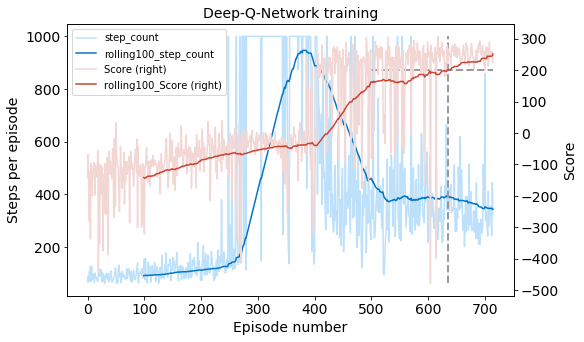

In [738]:
#color_dict_graph1 = {'rolling100_Score': '#CB4335', 'Score': '#F2D7D5','step_count' : '#EBF5FB','rolling100_step_count' : '#85C1E9'}
color_dict_graph1 = {'rolling100_Score': '#CB4335', 'Score': '#F2D7D5','step_count' : '#BEE1FB','rolling100_step_count' : '#0474C5'}
graph1_df = training_model_info[training_model_info["model_name"] == "LeakyReLU_LunarLander_v2_base"][['episode_no', 'Score', 'step_count','rolling_step_count',
       'rolling_Score']]

graph1_df.columns = ['episode_no', 'Score', 'step_count', 'rolling100_step_count','rolling100_Score']
plt.rcParams.update({'font.size': 10})
plt.figure()


ax_graph1_step = graph1_df[['episode_no', 'step_count','rolling100_step_count']].plot(x='episode_no', rot=0, 
                          color=[color_dict_graph1.get(x, '#333333') for x in['step_count','rolling100_step_count']],
                          kind='line',style ='-',fontsize=14,figsize=(8,5) )
ax_graph1_score = graph1_df[['episode_no', 'Score','rolling100_Score']].plot(x='episode_no', rot=0, 
                          color=[color_dict_graph1.get(x, '#9D9899') for x in['Score', 'rolling100_Score']],zorder=3,
                          kind='line',style ='-',fontsize=14,figsize=(8,5),secondary_y=True,ax =ax_graph1_step)



plt.hlines(y=200, xmin=500,xmax=len(graph1_df), color='#9D9899', linestyle='--',lw=2,zorder =-1)
plt.vlines(x=training_model_info.loc[((training_model_info["model_name"] == "LeakyReLU_LunarLander_v2_base") & (training_model_info['reached_goal'] ==True)), ]["episode_no"],
           ymin=graph1_df.Score.min(),ymax=graph1_df.Score.max(), color='#9D9899', linestyle='--',lw=2,zorder =-1)


ax_graph1_step.set_title('Deep-Q-Network training',fontsize=14)
ax_graph1_step.set_xlabel('Episode number',fontsize=14)
ax_graph1_step.set_ylabel('Steps per episode',fontsize=14)
ax_graph1_score.set_ylabel('Score',fontsize=14)

#ax_graph1_step.legend(loc = "upper left")
plt.savefig('./model_data/test_data_check/P2_graph1.png', bbox_inches='tight')
plt.show()




<Figure size 432x288 with 0 Axes>

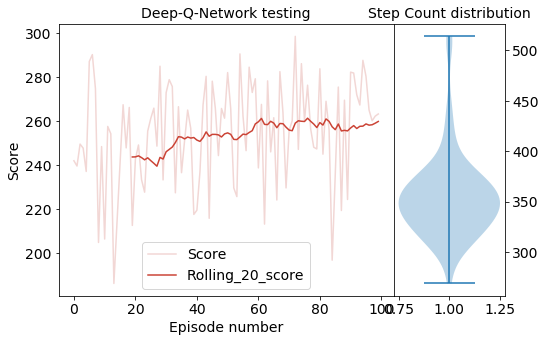

In [742]:
#graph2_200_df


graph2_200_df = test_model_info_200[test_model_info_200["model_name"] == "LeakyReLU_LunarLander_v2_base"][['episode_no', 'Score', 'step_count']]
graph2_200_df["Rolling_20_score"] = graph2_200_df["Score"].rolling(20).mean()

color_dict_graph2 = {'Rolling_20_score': '#CB4335', 'Score': '#F2D7D5'}


plt.figure()
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]},figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax_graph2_score_200 = graph2_200_df[['episode_no', 'Score','Rolling_20_score']].plot(x='episode_no', rot=0, 
                          color=[color_dict_graph2.get(x, '#333333') for x in['Score','Rolling_20_score']],
                          kind='line',style ='-',fontsize=14, ax= a0)

a1.violinplot(dataset = [graph2_200_df['step_count']])

#,subplots=True, layout=(1,2))
#ax_graph2_score_250 = graph2_250_df[['episode_no', 'Score']].plot(x='episode_no', rot=0, 
#                          color="#D815CC",zorder=3,
#                          kind='line',style ='-',fontsize=14,figsize=(8,6),ax =ax_graph2_score_200)



ax_graph2_score_200.set_title('Deep-Q-Network testing',fontsize=14)
ax_graph2_score_200.set_xlabel('Episode number',fontsize=14)
ax_graph2_score_200.set_ylabel('Score',fontsize=14)
a1.set_title('Step Count distribution',fontsize=14)
#ax_graph2_score_200.set_ylabel('Score',fontsize=14)


a1.yaxis.set_ticks_position("right")
plt.subplots_adjust(wspace=0, hspace=0)


#ax_graph1_step.legend(loc = "upper left")
plt.savefig('P2_graph2.png', bbox_inches='tight')

plt.show()



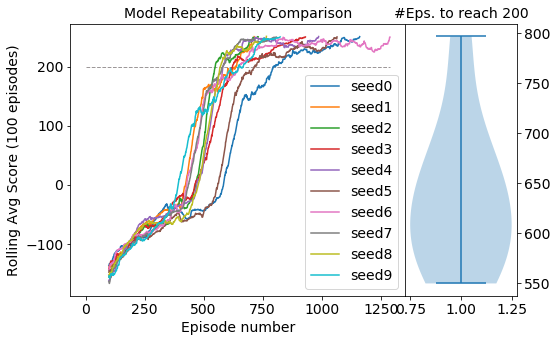

In [605]:
plt.rcParams.update({'font.size': 14})
f, (ax_repeat, a1_repeat) = plt.subplots(1, 2, figsize=(8,5),gridspec_kw={'width_ratios': [3, 1]})
graph_repeat_exp1 = training_model_info[training_model_info.model_identifier == "repeat"]

for name,group  in graph_repeat_exp1.groupby('identifier_param'):
        ax_repeat.plot(group['episode_no'] ,group['rolling_Score'], label = "seed"+name)
        #ax = group[['episode_no','rolling_Score']].plot(x='episode_no', rot=0, 
        #                  zorder=3,
        #                  kind='line',style ='-',fontsize=14,figsize=(8,6), ax = ax)
ax_repeat.legend(fontsize=14)
ax_repeat.set_title('Model Repeatability Comparison',fontsize=14)
ax_repeat.set_xlabel('Episode number',fontsize=14)
ax_repeat.set_ylabel('Rolling Avg Score (100 episodes)',fontsize=14)
#ax_repeat.yaxis.grid(True)



ax_repeat.hlines(y=200, xmin=graph_repeat_exp1["episode_no"].min(),xmax=graph_repeat_exp1["episode_no"].max(), color='#9D9899', linestyle='--',lw=1,zorder =-1)

a1_repeat.violinplot(dataset = [graph_repeat_exp1[graph_repeat_exp1['reached_goal'] ==True].episode_no])
a1_repeat.set_title('#Eps. to reach 200',fontsize=14)
a1_repeat.yaxis.set_ticks_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('P2_graph_repeat_ext.png', bbox_inches='tight')

plt.show()

In [606]:
print("Avg number of episodes taken to converge to 200", graph_repeat_exp1[graph_repeat_exp1['reached_goal'] ==True].episode_no.mean())
print("99% confidence interval z value as a proportion of avg episodes", 2.576*graph_repeat_exp1[graph_repeat_exp1['reached_goal'] ==True].episode_no.std()/graph_repeat_exp1[graph_repeat_exp1['reached_goal'] ==True].episode_no.mean())

#that is maximum deviation is 36 percent either side of the mean.

Avg number of episodes taken to converge to 200 637.3
99% confidence interval z value as a proportion of avg episodes 0.30338468892348086


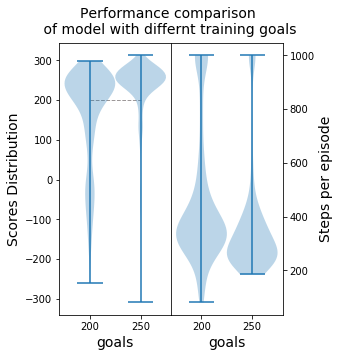

In [718]:
f, (a_repeat_score, a_repeat_step) = plt.subplots(1, 2, figsize=(4,5),gridspec_kw={'width_ratios': [1, 1]})

graph_repeat_exp200 = test_model_info_200[test_model_info_200.model_identifier == "repeat"]
graph_repeat_exp250 = test_model_info_250[test_model_info_250.model_identifier == "repeat"]

a_repeat_score.violinplot(dataset = [graph_repeat_exp200.Score,graph_repeat_exp250.Score],widths=1)
a_repeat_score.set_xticklabels([0,200,250])
#a_repeat_score.hlines(y=200, xmin=199,xmax=300, color='#9D9899', linestyle='--',lw=1,zorder =-1)
#a_repeat_score.yaxis.grid(True)
a_repeat_step.yaxis.set_ticks_position("right")
a_repeat_step.yaxis.set_label_position("right")

a_repeat_step.violinplot(dataset = [graph_repeat_exp200.step_count,graph_repeat_exp250.step_count],widths=1)
a_repeat_step.set_xticklabels([0,200,250])
#a_repeat_step.yaxis.grid(True)
a_repeat_score.set_xlabel('goals',fontsize=14)
#with 10 differnt training itterations
a_repeat_score.set_ylabel('Scores Distribution',fontsize=14)

a_repeat_step.set_xlabel('goals',fontsize=14)
a_repeat_step.set_ylabel('Steps per episode',fontsize=14)
f.suptitle("Performance comparison\n of model with differnt training goals", fontsize=14)
plt.savefig('P2_graph.png', bbox_inches='tight')
#,\n over 10 different itterations of 100 episodes"

a_repeat_score.hlines(y=200, xmin=1,xmax=2, color='#9D9899', linestyle='--',lw=1,zorder =-1)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('P2_graph_repeat_ext_2.png', bbox_inches='tight')

plt.show()

In [608]:
print("% of tests reaching 200 goal, for model trained till 200 avg score:",sum(graph_repeat_exp200['Score']>=200)/100*10,"%",
      "\n% of tests reaching 200 goal, for model trained till 250 avg score:",sum(graph_repeat_exp250['Score']>=200)/100*10,"%")

% of tests reaching 200 goal, for model trained till 200 avg score: 60.4 % 
% of tests reaching 200 goal, for model trained till 250 avg score: 86.6 %


In [609]:
print("Avg score when not reaching the goal, for model trained till 200 avg score:",graph_repeat_exp200[graph_repeat_exp200['Score']<200].Score.mean(),
      "\nAvg score when not reaching the goal, for model trained till 250 avg score:",graph_repeat_exp250[graph_repeat_exp250['Score']<200].Score.mean())

Avg score when not reaching the goal, for model trained till 200 avg score: 46.866874609402394 
Avg score when not reaching the goal, for model trained till 250 avg score: 105.85040375617761


In [610]:
print("% of tests hovering, for model trained till 200 avg score:",graph_repeat_exp200.Hovering.sum()/100*10,"%",graph_repeat_exp200[graph_repeat_exp200.Hovering ==1].Score.mean() ,
      "\n% of tests hovering, for model trained till 250 avg score:",graph_repeat_exp250.Hovering.sum()/100*10,"%",graph_repeat_exp250[graph_repeat_exp250.Hovering ==1].Score.mean())

% of tests hovering, for model trained till 200 avg score: 11.899999999999999 % 19.66322839660181 
% of tests hovering, for model trained till 250 avg score: 6.7 % 71.92801003630935


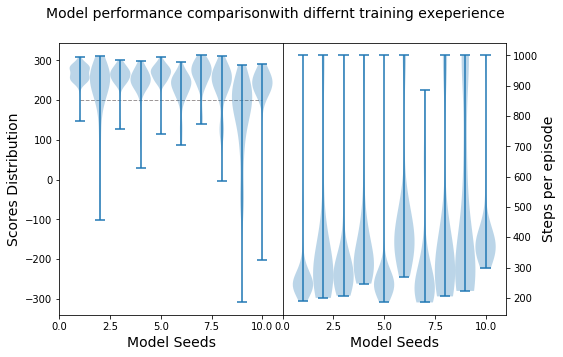

In [719]:
repeat_test_grapher_df = test_model_info_250[test_model_info_250["model_identifier"] == "repeat"].set_index("episode_no")
#repeat_test_grapher_df.groupby('identifier_param')["step_count"].plot(legend=True)

f_rtg,(a_rtg_score,a_rtg_steps) = plt.subplots(1, 2, figsize=(8,5),gridspec_kw={'width_ratios': [1, 1]})
plt.rcParams.update({'font.size': 14})


a_rtg_score.violinplot(dataset = [group["Score"] for name, group in repeat_test_grapher_df.groupby('identifier_param')],widths=1)
a_rtg_steps.violinplot(dataset = [group["step_count"] for name, group in repeat_test_grapher_df.groupby('identifier_param')],widths=1)

a_rtg_steps.yaxis.set_ticks_position("right")
a_rtg_steps.yaxis.set_label_position("right")

a_rtg_score.set_xlabel('Model Seeds',fontsize=14)
#with 10 differnt training itterations
a_rtg_score.set_ylabel('Scores Distribution',fontsize=14)

a_rtg_steps.set_xlabel('Model Seeds',fontsize=14)
a_rtg_steps.set_ylabel('Steps per episode',fontsize=14)
f_rtg.suptitle("Model performance comparisonwith differnt training exeperience", fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)

a_rtg_score.hlines(y=200, xmin=1,xmax=10, color='#9D9899', linestyle='--',lw=1,zorder =-1)
plt.savefig('P2_graph_repeat_ext_3.png', bbox_inches='tight')


plt.show()

<Figure size 432x288 with 0 Axes>

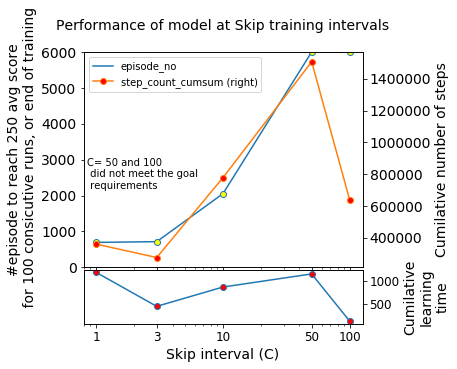

In [681]:


plt.figure()

plt.rcParams.update({'font.size': 10})

Experiment_1_C_training_summary =   table_for_analysis[table_for_analysis["model_identifier"] == "C" ]
f_exp1ct1,(a_exp1ct1_eps_step,a_exp1ct1_time) = plt.subplots(2,1, figsize=(5,5), gridspec_kw={'height_ratios': [4,1]}, sharex=True)

#Experiment_1_C_training_summary.sort_values("identifier_param")


Experiment_1_C_training_summary_episode = Experiment_1_C_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['episode_no'] ,logx=True,
                                                                                                                    style ='-',marker ="o",fontsize=14,
                                  markerfacecolor='yellow', legend=True, ax = a_exp1ct1_eps_step,
                                                                                                                    x_compat=True)
Experiment_1_C_training_summary_step = Experiment_1_C_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['step_count_cumsum'],
                                                                                            secondary_y=True,ax =Experiment_1_C_training_summary_episode,
                                                                                                                marker ="o",fontsize=14,
                                  markerfacecolor='red', legend=True
                                                                                                                )

Experiment_1_C_training_summary_episode_ticks =list(Experiment_1_C_training_summary.sort_values("identifier_param")["identifier_param"])
Experiment_1_C_training_summary_episode.set_xticklabels(Experiment_1_C_training_summary_episode_ticks)
Experiment_1_C_training_summary_episode.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(Experiment_1_C_training_summary_episode_ticks)
Experiment_1_C_training_summary_episode.set_ylim(0,6000)
Experiment_1_C_training_summary_episode.set_title('Performance of model at Skip training intervals\n',fontsize=14)
Experiment_1_C_training_summary_episode.set_ylabel('#episode to reach 250 avg score\n for 100 consicutive runs, or end of training',fontsize=14)
Experiment_1_C_training_summary_step.set_ylabel('Cumilative number of steps',fontsize=14)



a_exp1ct1_time.set_xlabel('Skip interval (C)',fontsize=14)
Experiment_1_C_training_summary_time = Experiment_1_C_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['exec_time_cumsum'],
                                                                                            secondary_y=True,
                                                                                                                marker ="o",fontsize=12,
                                  markerfacecolor='red', legend=False, ax =a_exp1ct1_time
                                                                                                                )

#Experiment_1_C_training_summary_step.set_xlabel('Skip interval (C)',fontsize=14)
a_exp1ct1_time.set_xlabel('Skip interval (C)',fontsize=14)
Experiment_1_C_training_summary_time.set_ylabel('Cumilative\nlearning\ntime',fontsize=14)

#ax_graph1_score.set_ylabel('Score',fontsize=14)
#ax_graph1_step.legend(loc = "upper left")

plt.figtext(.135, .5, "C= 50 and 100\n did not meet the goal\n requirements")
plt.subplots_adjust(wspace=0, hspace=0.02)
#plt.savefig('P2_graph1.png', bbox_inches='tight')



plt.savefig('P2_experiment_1_C_1.png', bbox_inches='tight')
plt.show()




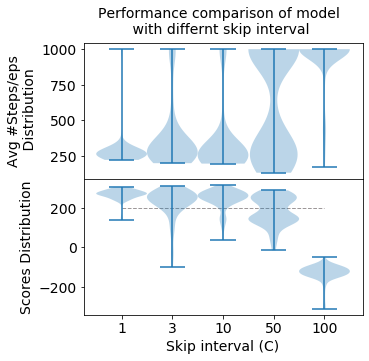

In [725]:
Experiment_1_C_test_summary = test_model_info_250[test_model_info_250["model_identifier"] == "C"].set_index("episode_no")
#repeat_test_grapher_df.groupby('identifier_param')["step_count"].plot(legend=True)
Experiment_1_C_test_summary['identifier_param'] = Experiment_1_C_test_summary['identifier_param'].astype("int")

Experiment_1_C_test_summary.sort_values('identifier_param',inplace= True)


f_exp1ct,(a_exp1ct_steps,a_exp1ct_score) = plt.subplots(2, figsize=(5,5))
plt.rcParams.update({'font.size': 14})
#dataset = 

label_names_a_exp1ct_score = list([name for name, group in Experiment_1_C_test_summary.groupby('identifier_param')])

a_exp1ct_score.violinplot([group["Score"] for name, group in Experiment_1_C_test_summary.groupby('identifier_param')],
                          range(len(label_names_a_exp1ct_score)),widths=1, vert=True)


a_exp1ct_score.set_xticks(range(len(label_names_a_exp1ct_score)))

a_exp1ct_score.set_xticklabels(label_names_a_exp1ct_score)



a_exp1ct_steps.violinplot([group["step_count"] for name, group in Experiment_1_C_test_summary.groupby('identifier_param')],
                         range(len(label_names_a_exp1ct_score)),widths=1, vert=True)

#a_exp1ct_steps.yaxis.set_ticks_position("right")
#a_exp1ct_steps.yaxis.set_label_position("right")

a_exp1ct_score.set_xlabel('Skip interval (C)',fontsize=14)
#with 10 differnt training itterations
a_exp1ct_score.set_ylabel('Scores Distribution',fontsize=14)

a_exp1ct_steps.set_ylabel('Avg #Steps/eps\n Distribution',fontsize=14)
a_exp1ct_steps.xaxis.set_visible(False)

#a_exp1ct_steps.legend([name for name, group in Experiment_1_C_test_summary.groupby('identifier_param')])
#a_exp1ct_score.legend([name for name, group in Experiment_1_C_test_summary.groupby('identifier_param')])


f_exp1ct.suptitle("Performance comparison of model\n with differnt skip interval", fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)

a_exp1ct_score.hlines(y=200, xmin=0,xmax=len(label_names_a_exp1ct_score)-1, color='#9D9899', linestyle='--',lw=1,zorder =-1)
plt.savefig('P2_experiment_1_C_2.png', bbox_inches='tight')


plt.show()

<Figure size 432x288 with 0 Axes>

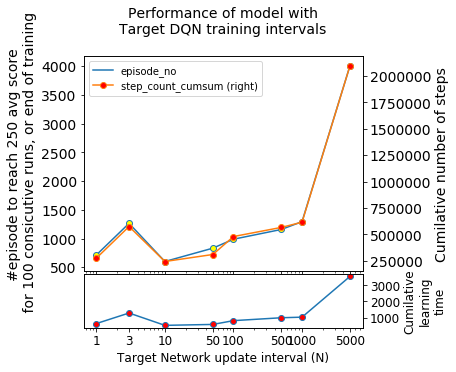

In [701]:

plt.figure()

plt.rcParams.update({'font.size': 10})

Experiment_1_N_training_summary =   table_for_analysis[table_for_analysis["model_identifier"] == "_N" ]
f_exp2nt1,(a_exp2nt1_eps_step,a_exp2nt1_time) = plt.subplots(2,1, figsize=(5,5), gridspec_kw={'height_ratios': [4,1]}, sharex=True)

#Experiment_1_C_training_summary.sort_values("identifier_param")


Experiment_1_N_training_summary_episode = Experiment_1_N_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['episode_no'] ,logx=True,
                                                                                                                    style ='-',marker ="o",fontsize=14,
                                  markerfacecolor='yellow', legend=True, ax = a_exp2nt1_eps_step,
                                                                                                                    x_compat=True)
Experiment_1_N_training_summary_step = Experiment_1_N_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['step_count_cumsum'],
                                                                                            secondary_y=True,ax =Experiment_1_N_training_summary_episode,
                                                                                                                marker ="o",fontsize=14,
                                  markerfacecolor='red', legend=True
                                                                                                                )

Experiment_1_N_training_summary_episode_ticks =list(Experiment_1_N_training_summary.sort_values("identifier_param")["identifier_param"])
Experiment_1_N_training_summary_episode.set_xticklabels(Experiment_1_N_training_summary_episode_ticks)
Experiment_1_N_training_summary_episode.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(Experiment_1_N_training_summary_episode_ticks)
#Experiment_1_C_training_summary_episode.set_ylim(0,6000)
Experiment_1_N_training_summary_episode.set_title('Performance of model with\nTarget DQN training intervals\n',fontsize=14)
Experiment_1_N_training_summary_episode.set_ylabel('#episode to reach 250 avg score\n for 100 consicutive runs, or end of training',fontsize=14)
Experiment_1_N_training_summary_step.set_ylabel('Cumilative number of steps',fontsize=14)




Experiment_1_N_training_summary_time = Experiment_1_N_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['exec_time_cumsum'],
                                                                                            secondary_y=True,
                                                                                                                marker ="o",fontsize=12,
                                  markerfacecolor='red', legend=False, ax =a_exp2nt1_time
                                                                                                                )


#Experiment_1_N_training_summary_time.set_xlabel('Skip interval (C)',fontsize=14)
Experiment_1_N_training_summary_time.set_ylabel('Cumilative\nlearning\ntime',fontsize=12)

#ax_graph1_score.set_ylabel('Score',fontsize=14)
#ax_graph1_step.legend(loc = "upper left")

#plt.figtext(.135, .5, "C= 50 and 100\n did not meet the goal\n requirements")
plt.subplots_adjust(wspace=0, hspace=0.02)
a_exp2nt1_time.set_xlabel('Target Network update interval (N)',fontsize=12)



#plt.ticklabel_format(style='sci', axis='x', scilimits=(1,1))
#plt.savefig('P2_graph1.png', bbox_inches='tight')
plt.savefig('P2_experiment_2_N_1.png', bbox_inches='tight')
plt.show()




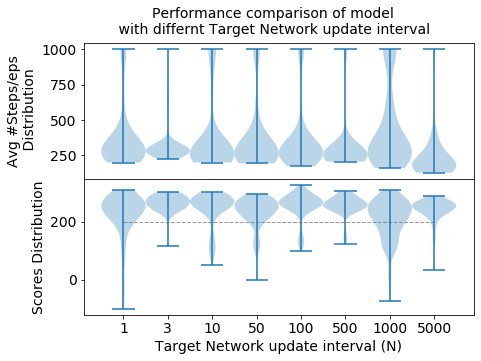

In [726]:
Experiment_1_N_test_summary = test_model_info_250[test_model_info_250["model_identifier"] == "_N"].set_index("episode_no")
#repeat_test_grapher_df.groupby('identifier_param')["step_count"].plot(legend=True)
Experiment_1_N_test_summary['identifier_param'] = Experiment_1_N_test_summary['identifier_param'].astype("int")

Experiment_1_N_test_summary.sort_values('identifier_param',inplace= True)

plt.rcParams.update({'font.size': 14})
f_exp2nt2,(a_exp2nt2_steps,a_exp2nt2_score) = plt.subplots(2, figsize=(7,5), sharex=True)

#dataset = 

label_names_a_exp2nt2_score = list([name for name, group in Experiment_1_N_test_summary.groupby('identifier_param')])

a_exp2nt2_score.violinplot([group["Score"] for name, group in Experiment_1_N_test_summary.groupby('identifier_param')],
                          range(len(label_names_a_exp2nt2_score)),widths=1, vert=True)


a_exp2nt2_score.set_xticks(range(len(label_names_a_exp2nt2_score)))

a_exp2nt2_score.set_xticklabels(label_names_a_exp2nt2_score)



a_exp2nt2_steps.violinplot([group["step_count"] for name, group in Experiment_1_N_test_summary.groupby('identifier_param')],
                         range(len(label_names_a_exp2nt2_score)),widths=1, vert=True)

#a_exp2nt2_steps.yaxis.set_ticks_position("right")
#a_exp2nt2_steps.yaxis.set_label_position("right")

a_exp2nt2_score.set_xlabel('Target Network update interval (N)',fontsize=14)
#with 10 differnt training itterations
a_exp2nt2_score.set_ylabel('Scores Distribution',fontsize=14)

a_exp2nt2_steps.set_ylabel('Avg #Steps/eps\n Distribution',fontsize=14)
a_exp2nt2_steps.xaxis.set_visible(False)

#a_exp2nt2_steps.legend([name for name, group in Experiment_1_N_test_summary.groupby('identifier_param')])
#a_exp2nt2_score.legend([name for name, group in Experiment_1_N_test_summary.groupby('identifier_param')])


f_exp2nt2.suptitle("Performance comparison of model\n with differnt Target Network update interval", fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)
plt.hlines(y=200, xmin=0,xmax=len(label_names_a_exp2nt2_score)-1, color='#9D9899', linestyle='--',lw=1,zorder =-1)


plt.savefig('P2_experiment_2_N_2.png', bbox_inches='tight')


plt.show()

<Figure size 432x288 with 0 Axes>

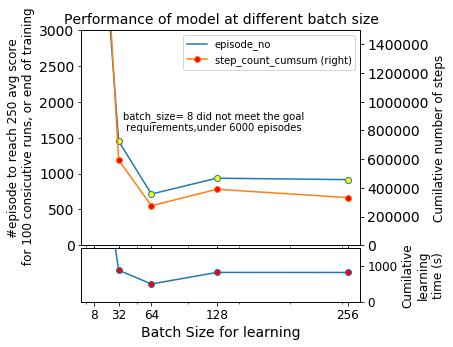

In [666]:

plt.figure()

plt.rcParams.update({'font.size': 10})

Experiment_3_batch_training_summary =   table_for_analysis[table_for_analysis["model_identifier"] == "batch_size" ]
f_exp3bt1,(a_exp3bt1_eps_step,a_exp3bt1_time) = plt.subplots(2,1, figsize=(5,5), gridspec_kw={'height_ratios': [4,1]}, sharex=True)

#Experiment_1_C_training_summary.sort_values("identifier_param")


Experiment_3_batch_training_summary_episode = Experiment_3_batch_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['episode_no'] ,logy=False,
                                                                                                                    style ='-',marker ="o",fontsize=14,
                                  markerfacecolor='yellow', legend=True, ax = a_exp3bt1_eps_step,
                                                                                                                    x_compat=True)
Experiment_3_batch_training_summary_step = Experiment_3_batch_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['step_count_cumsum'],
                                                                                            secondary_y=True,ax =Experiment_3_batch_training_summary_episode,
                                                                                                                marker ="o",fontsize=14,
                                  markerfacecolor='red', legend=True
                                                                                                                )

Experiment_3_batch_training_summary_episode_ticks =list(Experiment_3_batch_training_summary.sort_values("identifier_param")["identifier_param"])
#Experiment_3_batch_training_summary_episode.set_xticks(range(len(Experiment_3_batch_training_summary_episode_ticks)))
#Experiment_3_batch_training_summary_episode.set_xticklabels(Experiment_3_batch_training_summary_episode_ticks)

plt.xticks(Experiment_3_batch_training_summary_episode_ticks)
Experiment_3_batch_training_summary_episode.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

Experiment_3_batch_training_summary_episode.set_ylim(0,3000)
Experiment_3_batch_training_summary_step.set_ylim(0,1500000)
Experiment_3_batch_training_summary_episode.set_title('Performance of model at different batch size',fontsize=14)
Experiment_3_batch_training_summary_episode.set_ylabel('#episode to reach 250 avg score\n for 100 consicutive runs, or end of training',fontsize=12)
Experiment_3_batch_training_summary_step.set_ylabel('Cumilative number of steps',fontsize=12)




Experiment_3_batch_training_summary_time = Experiment_3_batch_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['exec_time_cumsum'],
                                                                                            secondary_y=True,
                                                                                                                marker ="o",fontsize=12,
                                  markerfacecolor='red', legend=False, ax =a_exp3bt1_time
                                                                                                                )


#Experiment_3_batch_training_summary_time.set_xlabel('Skip interval (C)',fontsize=14)
Experiment_3_batch_training_summary_time.set_ylabel('Cumilative\nlearning\ntime (s)',fontsize=12)

#ax_graph1_score.set_ylabel('Score',fontsize=14)
#ax_graph1_step.legend(loc = "upper left")

plt.figtext(.24, .6, "batch_size= 8 did not meet the goal\n requirements,under 6000 episodes")
plt.subplots_adjust(wspace=0, hspace=0.02)
a_exp3bt1_time.set_xlabel('Batch Size for learning',fontsize=14)
Experiment_3_batch_training_summary_time.set_ylim(0,1500)
#plt.savefig('P2_graph1.png', bbox_inches='tight')

plt.savefig('P2_experiment_3_batch_size_1.png', bbox_inches='tight')
plt.show()




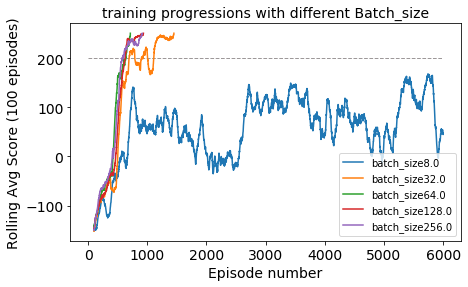

In [674]:
plt.rcParams.update({'font.size': 14})
f, ax_batch_size = plt.subplots(1, figsize=(7,4))
graph_batch_size_exp1 = training_model_info[training_model_info.model_identifier == "batch_size"]

for name,group  in graph_batch_size_exp1.groupby('identifier_param'):
        ax_batch_size.plot(group['episode_no'] ,group['rolling_Score'], label = "batch_size"+str(name))
        #ax = group[['episode_no','rolling_Score']].plot(x='episode_no', rot=0, 
        #                  zorder=3,
        #                  kind='line',style ='-',fontsize=14,figsize=(8,6), ax = ax)
ax_batch_size.legend(fontsize=10)
ax_batch_size.set_title('training progressions with different Batch_size',fontsize=14)
ax_batch_size.set_xlabel('Episode number',fontsize=14)
ax_batch_size.set_ylabel('Rolling Avg Score (100 episodes)',fontsize=14)
#ax_batch_size.yaxis.grid(True)



ax_batch_size.hlines(y=200, xmin=graph_batch_size_exp1["episode_no"].min(),xmax=graph_batch_size_exp1["episode_no"].max(), color='#9D9899', linestyle='--',lw=1,zorder =-1)

#a1_batch_size.violinplot(dataset = [graph_batch_size_exp1[graph_batch_size_exp1['reached_goal'] ==True].episode_no])
#a1_batch_size.set_title('#Eps. to reach 200',fontsize=14)
#a1_batch_size.yaxis.set_ticks_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('P2_experiment_3_batch_size_1_1.png', bbox_inches='tight')

plt.show()

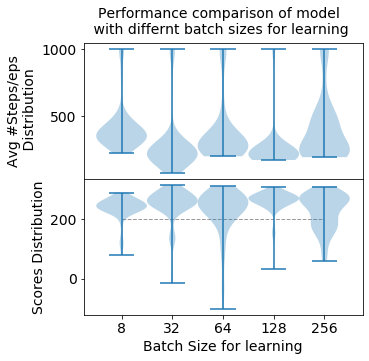

In [727]:
Experiment_3_batch_size_test_summary = test_model_info_250[test_model_info_250["model_identifier"] == "batch_size"].set_index("episode_no")
#repeat_test_grapher_df.groupby('identifier_param')["step_count"].plot(legend=True)
Experiment_3_batch_size_test_summary['identifier_param'] = Experiment_3_batch_size_test_summary['identifier_param'].astype("int")

Experiment_3_batch_size_test_summary.sort_values('identifier_param',inplace= True)

plt.rcParams.update({'font.size': 14})
f_exp3bt2,(a_exp3bt2_steps,a_exp3bt2_score) = plt.subplots(2, figsize=(5,5), sharex=True)

#dataset = 

label_names_a_exp3bt2_score = list([name for name, group in Experiment_3_batch_size_test_summary.groupby('identifier_param')])

a_exp3bt2_score.violinplot([group["Score"] for name, group in Experiment_3_batch_size_test_summary.groupby('identifier_param')],
                          range(len(label_names_a_exp3bt2_score)),widths=1, vert=True)


a_exp3bt2_score.set_xticks(range(len(label_names_a_exp3bt2_score)))

a_exp3bt2_score.set_xticklabels(label_names_a_exp3bt2_score)



a_exp3bt2_steps.violinplot([group["step_count"] for name, group in Experiment_3_batch_size_test_summary.groupby('identifier_param')],
                         range(len(label_names_a_exp3bt2_score)),widths=1, vert=True)

#a_exp3bt2_steps.yaxis.set_ticks_position("right")
#a_exp3bt2_steps.yaxis.set_label_position("right")

a_exp3bt2_score.set_xlabel('Batch Size for learning',fontsize=14)
#with 10 differnt training itterations
a_exp3bt2_score.set_ylabel('Scores Distribution',fontsize=14)

a_exp3bt2_steps.set_ylabel('Avg #Steps/eps\n Distribution',fontsize=14)
a_exp3bt2_steps.xaxis.set_visible(False)

#a_exp3bt2_steps.legend([name for name, group in Experiment_3_batch_size_test_summary.groupby('identifier_param')])
#a_exp3bt2_score.legend([name for name, group in Experiment_3_batch_size_test_summary.groupby('identifier_param')])


f_exp3bt2.suptitle("Performance comparison of model\n with differnt batch sizes for learning", fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)
plt.hlines(y=200, xmin=0,xmax=len(label_names_a_exp3bt2_score)-1, color='#9D9899', linestyle='--',lw=1,zorder =-1)


plt.savefig('P2_experiment_3_batch_size_2.png', bbox_inches='tight')


plt.show()

<Figure size 432x288 with 0 Axes>

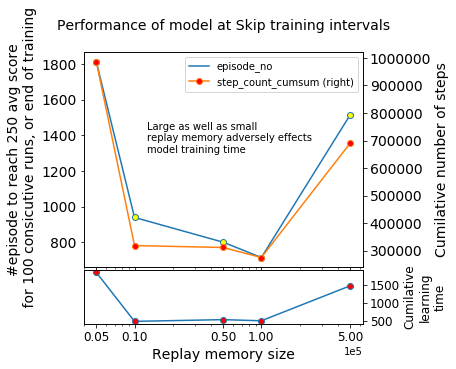

In [712]:

plt.figure()

plt.rcParams.update({'font.size': 10})

Experiment_2_replay_memory_size_training_summary =   table_for_analysis[table_for_analysis["model_identifier"] == "replay_memory_size" ]
f_exp4rmt1,(a_exp4rmt1_eps_step,a_exp4rmt1_time) = plt.subplots(2,1, figsize=(5,5), gridspec_kw={'height_ratios': [4,1]}, sharex=True)

#Experiment_2_C_training_summary.sort_values("identifier_param")


Experiment_2_replay_memory_size_training_summary_episode = Experiment_2_replay_memory_size_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['episode_no'] ,logx=True,
                                                                                                                    style ='-',marker ="o",fontsize=14,
                                  markerfacecolor='yellow', legend=True, ax = a_exp4rmt1_eps_step,
                                                                                                                    x_compat=True)
Experiment_2_replay_memory_size_training_summary_step = Experiment_2_replay_memory_size_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['step_count_cumsum'],
                                                                                            secondary_y=True,ax =Experiment_2_replay_memory_size_training_summary_episode,
                                                                                                                marker ="o",fontsize=14,
                                  markerfacecolor='red', legend=True
                                                                                                                )

Experiment_2_replay_memory_size_training_summary_episode_ticks =list(Experiment_2_replay_memory_size_training_summary.sort_values("identifier_param")["identifier_param"])
Experiment_2_replay_memory_size_training_summary_episode.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(Experiment_2_replay_memory_size_training_summary_episode_ticks)
#Experiment_2_replay_memory_size_training_summary_episode.set_xticklabels(Experiment_2_replay_memory_size_training_summary_episode_ticks,rotation=45)

#Experiment_2_C_training_summary_episode.set_ylim(0,6000)
Experiment_2_replay_memory_size_training_summary_episode.set_title('Performance of model at Skip training intervals\n',fontsize=14)
Experiment_2_replay_memory_size_training_summary_episode.set_ylabel('#episode to reach 250 avg score\n for 100 consicutive runs, or end of training',fontsize=14)
Experiment_2_replay_memory_size_training_summary_step.set_ylabel('Cumilative number of steps',fontsize=14)




Experiment_2_replay_memory_size_training_summary_time = Experiment_2_replay_memory_size_training_summary.sort_values("identifier_param").plot.line(x='identifier_param',y =['exec_time_cumsum'],
                                                                                            secondary_y=True,
                                                                                                                marker ="o",fontsize=12,
                                  markerfacecolor='red', legend=False, ax =a_exp4rmt1_time
                                                                                                                )


#Experiment_2_replay_memory_size_training_summary_time.set_xlabel('Skip interval (C)',fontsize=14)
Experiment_2_replay_memory_size_training_summary_time.set_ylabel('Cumilative\nlearning\ntime',fontsize=12)

#ax_graph1_score.set_ylabel('Score',fontsize=14)
#ax_graph1_step.legend(loc = "upper left")

plt.figtext(.3, .6, "Large as well as small\nreplay memory adversely effects\nmodel training time")
plt.subplots_adjust(wspace=0, hspace=0.02)
a_exp4rmt1_time.set_xlabel('Replay memory size',fontsize=14)
plt.xticks(rotation=40)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig('P2_experiment_3_replay_memory_1.png', bbox_inches='tight')

plt.show()




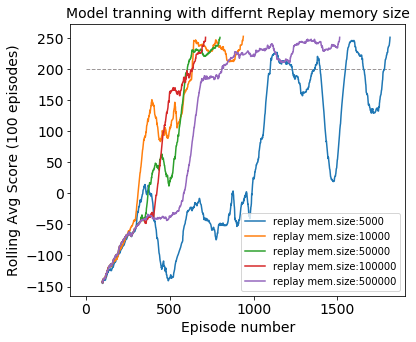

In [736]:
plt.rcParams.update({'font.size': 14})
f, ax_replay_memory_size = plt.subplots(1, figsize=(6,5))
graph_replay_memory_size_exp1 = training_model_info[training_model_info.model_identifier == "replay_memory_size"]

for name,group  in graph_replay_memory_size_exp1.groupby('identifier_param'):
        ax_replay_memory_size.plot(group['episode_no'] ,group['rolling_Score'], label = "replay mem.size:"+str(int(name) ))
        #ax = group[['episode_no','rolling_Score']].plot(x='episode_no', rot=0, 
        #                  zorder=3,
        #                  kind='line',style ='-',fontsize=14,figsize=(8,6), ax = ax)
ax_replay_memory_size.legend(fontsize=10)
ax_replay_memory_size.set_title('Model tranning with differnt Replay memory size',fontsize=14)
ax_replay_memory_size.set_xlabel('Episode number',fontsize=14)
ax_replay_memory_size.set_ylabel('Rolling Avg Score (100 episodes)',fontsize=14)
#ax_replay_memory_size.yaxis.grid(True)



ax_replay_memory_size.hlines(y=200, xmin=graph_replay_memory_size_exp1["episode_no"].min(),xmax=graph_replay_memory_size_exp1["episode_no"].max(), color='#9D9899', linestyle='--',lw=1,zorder =-1)

#a1_replay_memory_size.violinplot(dataset = [graph_replay_memory_size_exp1[graph_replay_memory_size_exp1['reached_goal'] ==True].episode_no])
#a1_replay_memory_size.set_title('#Eps. to reach 200',fontsize=14)
#a1_replay_memory_size.yaxis.set_ticks_position("right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('P2_experiment_3_replay_memory_1_1.png', bbox_inches='tight')

plt.show()

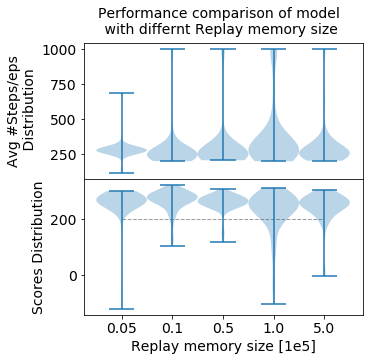

In [728]:
Experiment_4_replay_memory_size_test_summary = test_model_info_250[test_model_info_250["model_identifier"] == "replay_memory_size"].set_index("episode_no")
#repeat_test_grapher_df.groupby('identifier_param')["step_count"].plot(legend=True)
Experiment_4_replay_memory_size_test_summary['identifier_param'] = Experiment_4_replay_memory_size_test_summary['identifier_param'].astype("int")

Experiment_4_replay_memory_size_test_summary.sort_values('identifier_param',inplace= True)

plt.rcParams.update({'font.size': 14})
f_exp4rmt2,(a_exp4rmt2_steps,a_exp4rmt2_score) = plt.subplots(2, figsize=(5,5), sharex=True)

#dataset = 

label_names_a_exp4rmt2_score = list([int(name)/100000 for name, group in Experiment_4_replay_memory_size_test_summary.groupby('identifier_param')])

a_exp4rmt2_score.violinplot([group["Score"] for name, group in Experiment_4_replay_memory_size_test_summary.groupby('identifier_param')],
                          range(len(label_names_a_exp4rmt2_score)),widths=1, vert=True)


a_exp4rmt2_score.set_xticks(range(len(label_names_a_exp4rmt2_score)))

a_exp4rmt2_score.set_xticklabels(label_names_a_exp4rmt2_score)



a_exp4rmt2_steps.violinplot([group["step_count"] for name, group in Experiment_4_replay_memory_size_test_summary.groupby('identifier_param')],
                         range(len(label_names_a_exp4rmt2_score)),widths=1, vert=True)

#a_exp4rmt2_steps.yaxis.set_ticks_position("right")
#a_exp4rmt2_steps.yaxis.set_label_position("right")

a_exp4rmt2_score.set_xlabel('Replay memory size [1e5]',fontsize=14)
#with 10 differnt training itterations
a_exp4rmt2_score.set_ylabel('Scores Distribution',fontsize=14)

a_exp4rmt2_steps.set_ylabel('Avg #Steps/eps\n Distribution',fontsize=14)
a_exp4rmt2_steps.xaxis.set_visible(False)

#a_exp4rmt2_steps.legend([name for name, group in Experiment_4_replay_memory_size_test_summary.groupby('identifier_param')])
#a_exp4rmt2_score.legend([name for name, group in Experiment_4_replay_memory_size_test_summary.groupby('identifier_param')])


f_exp4rmt2.suptitle("Performance comparison of model\n with differnt Replay memory size", fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)


a_exp4rmt2_score.hlines(y=200, xmin=0,xmax=len(label_names_a_exp4rmt2_score)-1, color='#9D9899', linestyle='--',lw=1,zorder =-1)

plt.savefig('P2_experiment_3_replay_memory_2.png', bbox_inches='tight')

plt.show()